In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce
from scipy.signal import argrelextrema

In [2]:
plt.style.use('ggplot')

In [3]:
path = 'C:\\Work\Projects\\python\\flask\strategies\\data'

In [4]:

pairs_list = []
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        pairs_list.append(filename.split('.')[0])
print(pairs_list)


['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']


In [5]:

df = {}
for pair in range(len(pairs_list)):
    df[pair] = pd.read_csv(path + '\\' + pairs_list[pair]+'.csv', header = 0)
    df[pair].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
    df[pair]['Date'] = df[pair]['Date'].str.join(' ')
    df[pair].set_index('Date', inplace = True)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%d.%m.%Y %H:%M:%S.%f')
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair]['min'] = ''
    df[pair]['max'] = ''


In [6]:

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)


In [7]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5

plot_trades = False

In [8]:

for pair in range(len(pairs_list)):
    price = df[pair]['Close']
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['min'] = df[pair].iloc[argrelextrema(price.values, np.less_equal, order = 100)[0]]['Close']
    df[pair]['max'] = df[pair].iloc[argrelextrema(price.values, np.greater_equal, order = 100)[0]]['Close']
    if 'JPY' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  AUDUSD a
Pair:  EURUSD a
Pair:  GBPUSD a
Pair:  NZDUSD a
Pair:  USDCAD a
Pair:  USDCHF a
Pair:  USDJPY b


In [9]:
ATR(df[pair], 20)['ATR']

Date
2010-04-01 00:00:00        NaN
2010-04-01 01:00:00        NaN
2010-04-01 02:00:00        NaN
2010-04-01 03:00:00        NaN
2010-04-01 04:00:00        NaN
                        ...   
2020-04-24 17:00:00    0.10015
2020-04-24 18:00:00    0.09900
2020-04-24 19:00:00    0.09540
2020-04-24 20:00:00    0.09165
2020-04-24 21:00:00    0.09480
Name: ATR, Length: 63052, dtype: float64

In [10]:

def trade_plot(df, trade, exit_price, exit_date):
    plt.figure(figsize = (25, 8))
    plt.title(trade['signal'] + ' - With result: ' + str(round(trade['result'], 2)))
    plt.plot(df['Close'][(trade['date_of_trade'] - datetime.timedelta(days = 1000)): (trade['date_of_trade'] + datetime.timedelta(days = 30))], color = 'blue')
    plt.axhline(trade['TP'], color = 'green', ls = ':')
    plt.axhline(trade['SL'], color = 'red', ls = ':')
    plt.scatter(df.index, df['min'], color = 'red', s = 100)
    plt.scatter(df.index, df['max'], color = 'green', s = 100)
    plt.scatter(trade['date_of_trade'], trade['entry_price'], color = 'yellow', s = 200)
    plt.scatter(exit_date, exit_price, color = 'orange', s = 200)

    plt.show()

In [11]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}
support = {}
resist = {}

In [12]:
df[pair].tail

<bound method NDFrame.tail of                         Open     High      Low    Close      Volume  Day  \
Date                                                                       
2010-04-01 00:00:00   93.600   93.655   93.530   93.530  11300.9004  Thu   
2010-04-01 01:00:00   93.530   93.530   93.360   93.400  27209.5000  Thu   
2010-04-01 02:00:00   93.400   93.430   93.285   93.330  31216.1992  Thu   
2010-04-01 03:00:00   93.330   93.460   93.315   93.390  20675.9004  Thu   
2010-04-01 04:00:00   93.390   93.430   93.350   93.410   8364.7002  Thu   
...                      ...      ...      ...      ...         ...  ...   
2020-04-24 17:00:00  107.447  107.502  107.414  107.461   5362.8600  Fri   
2020-04-24 18:00:00  107.460  107.470  107.435  107.447   2920.4300  Fri   
2020-04-24 19:00:00  107.447  107.468  107.414  107.439   2528.6200  Fri   
2020-04-24 20:00:00  107.439  107.441  107.382  107.395   3382.8400  Fri   
2020-04-24 21:00:00  107.396  107.548  107.373  107.540   

In [13]:

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []

    support[pair] = []
    resist[pair] = []

    for i in range(50, len(df[pair])):
        if (df[pair]['max'][i - 12] != '') and df[pair]['max'][i - 12] > 0:
            resist[pair].append(df[pair]['max'][i - 12])
        elif (df[pair]['max'][i - 12] != '') and df[pair]['min'][i - 12] > 0:
            support[pair].append(df[pair]['min'][i - 12])
        #Buy
        if support[pair] != [] and any(df[pair]['Close'][i - 1] > s for s in support[pair]) and any(df[pair]['Close'][i] <= s for s in support[pair])             and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
            support[pair].remove(support[pair][-1])

        #Sell
        if resist[pair] != [] and any(df[pair]['Close'][i - 1] < r for r in resist[pair]) and any(df[pair]['Close'][i] >= r for r in resist[pair])             and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            resist[pair].remove(resist[pair][-1])

        #Exit trades---------------------------------------------------------------------------
        #Buy Trailing SL
        if any(y <= df[pair]['Close'][i] for y in long_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    #Move SL to BE
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + df[pair]['spread'][i]})
                        print(j,
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_entry_price[pair] = []
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL)})
                        print(j,
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to second ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 3 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j,
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
        #Sell Trailing SL
        if any(y >= df[pair]['Close'][i] for y in short_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    #Move SL to BE
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - df[pair]['spread'][i]})
                        print(j,
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_entry_price[pair] = []
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL)})
                        print(j,
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 3 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j,
                             'Trailing SL to second ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])

        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])

        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                    #plot trade
                    if plot_trades == True:
                        trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if (i - trade[pair][j]['ID']) >= 12:
                        trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        #plot trade
                        if plot_trades == True:
                            trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])
                    elif (i - trade[pair][j]['ID']) >= 12:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j,
                             'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
                        #plot trade
                        if plot_trades == True:
                            trade_plot(df[pair][i - 1000: i + 30], trade[pair][j], df[pair]["Close"][i], df[pair].index[i])


451 New Long trade at price: 0.9161  On day: 2010-04-27 19:00:00 Pair: AUDUSD
451 Long loss at price: 0.9145 On day: 2010-04-27 20:00:00 With loss: -13.1925 

565 New Long trade at price: 0.9139  On day: 2010-05-04 13:00:00 Pair: AUDUSD
565 Long loss at price: 0.9122 On day: 2010-05-04 14:00:00 With loss: -11.7625 

772 New Long trade at price: 0.8731  On day: 2010-05-17 04:00:00 Pair: AUDUSD
772 Moved SL to BE: 0.8733 On day: 2010-05-17 05:00:00 

772 Trailing SL to first ATR: 0.8745 On day: 2010-05-17 05:00:00 

772 Long profit at price: 0.8799 On day: 2010-05-17 12:00:00 With profit: 64.775 

1248 New Short trade at price: 0.856  On day: 2010-06-14 00:00:00 Pair: AUDUSD
1248 Short loss at price: 0.8608 On day: 2010-06-14 10:00:00 With loss: -16.145 

1792 New Short trade at price: 0.8853  On day: 2010-07-14 16:00:00 Pair: AUDUSD
1792 Moved SL to BE: 0.8851 On day: 2010-07-14 17:00:00 

1792 Short loss at price: 0.8852 On day: 2010-07-14 21:00:00 With loss: -0.0 

1930 New Short trad

9245 New Long trade at price: 1.0028  On day: 2011-09-22 01:00:00 Pair: AUDUSD
9245 Moved SL to BE: 1.003 On day: 2011-09-22 02:00:00 

9245 Trailing SL to first ATR: 1.0048 On day: 2011-09-22 02:00:00 

9245 Long loss at price: 0.9996 On day: 2011-09-22 03:00:00 With loss: 17.3975 

9258 New Long trade at price: 0.9741  On day: 2011-09-22 14:00:00 Pair: AUDUSD
9258 Moved SL to BE: 0.9743 On day: 2011-09-22 15:00:00 

9258 Long loss at price: 0.974 On day: 2011-09-22 18:00:00 With loss: -0.0 

9415 New Long trade at price: 0.9645  On day: 2011-10-03 03:00:00 Pair: AUDUSD
9415 Long loss at price: 0.9604 On day: 2011-10-03 04:00:00 With loss: -17.9 

9433 New Long trade at price: 0.9529  On day: 2011-10-03 21:00:00 Pair: AUDUSD
9433 Long loss at price: 0.9492 On day: 2011-10-04 01:00:00 With loss: -22.95 

9769 New Short trade at price: 1.0378  On day: 2011-10-21 21:00:00 Pair: AUDUSD
9769 Moved SL to BE: 1.0376 On day: 2011-10-23 22:00:00 

9769 Trailing SL to first ATR: 1.0361 On day: 

16310 Moved SL to BE: 1.0472 On day: 2012-11-07 08:00:00 

16310 Short profit at price: 1.0436 On day: 2012-11-07 12:00:00 With profit: 28.05 

16609 New Short trade at price: 1.0467  On day: 2012-11-23 17:00:00 Pair: AUDUSD
16609 Moved SL to BE: 1.0465 On day: 2012-11-23 18:00:00 

16609 Short loss at price: 1.0467 On day: 2012-11-26 20:00:00 With loss: -0.0 

16640 New Short trade at price: 1.0481  On day: 2012-11-27 00:00:00 Pair: AUDUSD
16640 Moved SL to BE: 1.0479 On day: 2012-11-27 06:00:00 

16640 Short loss at price: 1.0485 On day: 2012-11-27 09:00:00 With loss: -0.0 

16817 New Short trade at price: 1.0487  On day: 2012-12-06 09:00:00 Pair: AUDUSD
16817 Short loss at price: 1.0495 On day: 2012-12-06 12:00:00 With loss: -8.34 

17095 New Long trade at price: 1.0395  On day: 2012-12-23 23:00:00 Pair: AUDUSD
17095 Moved SL to BE: 1.0397 On day: 2012-12-24 03:00:00 

17095 Long exited after 12 hours: 1.0408 On day: 2012-12-24 11:00:00 With profit: 10.8 

17424 New Short trade at p

23556 New Short trade at price: 0.8976  On day: 2014-01-03 04:00:00 Pair: AUDUSD
23556 Short loss at price: 0.8993 On day: 2014-01-03 09:00:00 With loss: -12.445 

23695 New Short trade at price: 0.9011  On day: 2014-01-12 23:00:00 Pair: AUDUSD
23695 Moved SL to BE: 0.9009 On day: 2014-01-13 00:00:00 

23695 Trailing SL to first ATR: 0.9001 On day: 2014-01-13 00:00:00 

23695 Short loss at price: 0.9027 On day: 2014-01-13 01:00:00 With loss: 7.74 

23768 New Long trade at price: 0.8816  On day: 2014-01-16 00:00:00 Pair: AUDUSD
23768 Long loss at price: 0.8805 On day: 2014-01-16 01:00:00 With loss: -11.1825 

23770 New Long trade at price: 0.8812  On day: 2014-01-16 02:00:00 Pair: AUDUSD
23770 Long loss at price: 0.8786 On day: 2014-01-16 08:00:00 With loss: -11.4975 

23777 New Long trade at price: 0.8796  On day: 2014-01-16 09:00:00 Pair: AUDUSD
23777 Long loss at price: 0.8787 On day: 2014-01-16 11:00:00 With loss: -10.9275 

23806 New Long trade at price: 0.8784  On day: 2014-01-17 

29129 Long loss at price: 0.8526 On day: 2014-11-25 13:00:00 With loss: -11.6475 

29326 New Long trade at price: 0.8323  On day: 2014-12-05 14:00:00 Pair: AUDUSD
29326 Moved SL to BE: 0.8325 On day: 2014-12-05 15:00:00 

29326 Long loss at price: 0.8321 On day: 2014-12-05 17:00:00 With loss: -0.0 

29618 New Long trade at price: 0.8096  On day: 2014-12-23 18:00:00 Pair: AUDUSD
29618 Moved SL to BE: 0.8098 On day: 2014-12-23 21:00:00 

29618 Long exited after 12 hours: 0.8109 On day: 2014-12-24 06:00:00 With profit: 10.9 

29813 New Long trade at price: 0.8092  On day: 2015-01-02 21:00:00 Pair: AUDUSD
29813 Long loss at price: 0.8076 On day: 2015-01-04 22:00:00 With loss: -8.0375 

29833 New Long trade at price: 0.8092  On day: 2015-01-05 17:00:00 Pair: AUDUSD
29833 Moved SL to BE: 0.8094 On day: 2015-01-06 00:00:00 

29833 Trailing SL to first ATR: 0.81 On day: 2015-01-06 00:00:00 

29833 Trailing SL to second ATR: 0.8109 On day: 2015-01-06 00:00:00 

29833 Long exited after 12 hours:

36912 Moved SL to BE: 0.7236 On day: 2016-02-22 21:00:00 

36912 Short loss at price: 0.7242 On day: 2016-02-23 06:00:00 With loss: -0.0 

37054 New Long trade at price: 0.7156  On day: 2016-03-01 14:00:00 Pair: AUDUSD
37054 Moved SL to BE: 0.7158 On day: 2016-03-01 16:00:00 

37054 Long profit at price: 0.7223 On day: 2016-03-02 00:00:00 With profit: 43.6875 

37079 New Short trade at price: 0.726  On day: 2016-03-02 15:00:00 Pair: AUDUSD
37079 Short loss at price: 0.7277 On day: 2016-03-02 17:00:00 With loss: -11.4275 

37095 New Short trade at price: 0.732  On day: 2016-03-03 07:00:00 Pair: AUDUSD
37095 Short loss at price: 0.7332 On day: 2016-03-03 10:00:00 With loss: -10.5775 

37103 New Short trade at price: 0.737  On day: 2016-03-03 15:00:00 Pair: AUDUSD
37103 Moved SL to BE: 0.7368 On day: 2016-03-03 16:00:00 

37103 Short loss at price: 0.7373 On day: 2016-03-03 18:00:00 With loss: -0.0 

37123 New Short trade at price: 0.7386  On day: 2016-03-04 11:00:00 Pair: AUDUSD
37123 Sh

43624 New Short trade at price: 0.7738  On day: 2017-03-20 07:00:00 Pair: AUDUSD
43624 Moved SL to BE: 0.7736 On day: 2017-03-20 08:00:00 

43624 Trailing SL to first ATR: 0.7732 On day: 2017-03-20 08:00:00 

43624 Short loss at price: 0.7734 On day: 2017-03-20 15:00:00 With loss: 4.08 

43881 New Long trade at price: 0.7592  On day: 2017-04-04 01:00:00 Pair: AUDUSD
43881 Moved SL to BE: 0.7594 On day: 2017-04-04 02:00:00 

43881 Trailing SL to first ATR: 0.7598 On day: 2017-04-04 02:00:00 

43881 Long loss at price: 0.7584 On day: 2017-04-04 05:00:00 With loss: 3.525 

43971 New Long trade at price: 0.7497  On day: 2017-04-07 19:00:00 Pair: AUDUSD
43971 Moved SL to BE: 0.7499 On day: 2017-04-10 00:00:00 

43971 Long loss at price: 0.7494 On day: 2017-04-10 02:00:00 With loss: -0.0 

43979 New Long trade at price: 0.7483  On day: 2017-04-10 03:00:00 Pair: AUDUSD
43979 Moved SL to BE: 0.7485 On day: 2017-04-10 06:00:00 

43979 Long loss at price: 0.7481 On day: 2017-04-10 08:00:00 With 

50464 New Long trade at price: 0.7657  On day: 2018-04-23 08:00:00 Pair: AUDUSD
50464 Long loss at price: 0.7647 On day: 2018-04-23 09:00:00 With loss: -7.7975 

50466 New Long trade at price: 0.7637  On day: 2018-04-23 10:00:00 Pair: AUDUSD
50466 Moved SL to BE: 0.7639 On day: 2018-04-23 11:00:00 

50466 Long loss at price: 0.7638 On day: 2018-04-23 13:00:00 With loss: -0.0 

50614 New Long trade at price: 0.7487  On day: 2018-05-01 14:00:00 Pair: AUDUSD
50614 Long loss at price: 0.7481 On day: 2018-05-01 15:00:00 With loss: -6.7825 

50729 New Long trade at price: 0.7472  On day: 2018-05-08 09:00:00 Pair: AUDUSD
50729 Long loss at price: 0.7458 On day: 2018-05-08 10:00:00 With loss: -8.8675 

50952 New Short trade at price: 0.7565  On day: 2018-05-21 16:00:00 Pair: AUDUSD
50952 Short loss at price: 0.7581 On day: 2018-05-21 20:00:00 With loss: -8.355 

51179 New Short trade at price: 0.7602  On day: 2018-06-04 03:00:00 Pair: AUDUSD
51179 Short loss at price: 0.7613 On day: 2018-06-04

57170 New Long trade at price: 0.6873  On day: 2019-05-17 18:00:00 Pair: AUDUSD
57170 Long loss at price: 0.6867 On day: 2019-05-17 19:00:00 With loss: -5.5275 

57410 New Short trade at price: 0.6938  On day: 2019-05-31 18:00:00 Pair: AUDUSD
57410 Moved SL to BE: 0.6936 On day: 2019-06-03 00:00:00 

57410 Short loss at price: 0.6944 On day: 2019-06-03 01:00:00 With loss: -0.0 

57634 New Long trade at price: 0.6894  On day: 2019-06-14 02:00:00 Pair: AUDUSD
57634 Moved SL to BE: 0.6896 On day: 2019-06-14 04:00:00 

57634 Long loss at price: 0.6884 On day: 2019-06-14 13:00:00 With loss: -0.0 

57649 New Long trade at price: 0.6865  On day: 2019-06-14 17:00:00 Pair: AUDUSD
57649 Moved SL to BE: 0.6867 On day: 2019-06-14 20:00:00 

57649 Long exited after 12 hours: 0.688 On day: 2019-06-17 05:00:00 With profit: 12.4 

57879 New Short trade at price: 0.7014  On day: 2019-06-28 07:00:00 Pair: AUDUSD
57879 Moved SL to BE: 0.7012 On day: 2019-06-28 10:00:00 

57879 Trailing SL to first ATR: 0

3715 New Short trade at price: 1.4102  On day: 2010-11-03 18:00:00 Pair: EURUSD
3715 Short loss at price: 1.4121 On day: 2010-11-03 19:00:00 With loss: -16.81 

3722 New Short trade at price: 1.4119  On day: 2010-11-04 01:00:00 Pair: EURUSD
3722 Short loss at price: 1.4136 On day: 2010-11-04 03:00:00 With loss: -18.425 

3819 New Long trade at price: 1.3744  On day: 2010-11-10 03:00:00 Pair: EURUSD
3819 Moved SL to BE: 1.3746 On day: 2010-11-10 05:00:00 

3819 Long loss at price: 1.3699 On day: 2010-11-10 14:00:00 With loss: -0.0 

3852 New Long trade at price: 1.3689  On day: 2010-11-11 12:00:00 Pair: EURUSD
3852 Moved SL to BE: 1.3691 On day: 2010-11-11 13:00:00 

3852 Long loss at price: 1.3675 On day: 2010-11-11 14:00:00 With loss: -0.0 

4386 New Short trade at price: 1.3418  On day: 2010-12-13 18:00:00 Pair: EURUSD
4386 Moved SL to BE: 1.3416 On day: 2010-12-13 19:00:00 

4386 Short loss at price: 1.3417 On day: 2010-12-14 06:00:00 With loss: -0.0 

4479 New Long trade at price: 

11762 New Long trade at price: 1.3025  On day: 2012-02-16 02:00:00 Pair: EURUSD
11762 Long loss at price: 1.3006 On day: 2012-02-16 06:00:00 With loss: -15.5125 

11889 New Short trade at price: 1.3326  On day: 2012-02-23 09:00:00 Pair: EURUSD
11889 Moved SL to BE: 1.3324 On day: 2012-02-23 10:00:00 

11889 Short loss at price: 1.3335 On day: 2012-02-23 18:00:00 With loss: -0.0 

12407 New Short trade at price: 1.3282  On day: 2012-03-25 23:00:00 Pair: EURUSD
12407 Moved SL to BE: 1.328 On day: 2012-03-26 01:00:00 

12407 Short profit at price: 1.3209 On day: 2012-03-26 09:00:00 With profit: 54.725 

12768 New Long trade at price: 1.3044  On day: 2012-04-16 00:00:00 Pair: EURUSD
12768 Long loss at price: 1.3014 On day: 2012-04-16 01:00:00 With loss: -11.22 

12775 New Long trade at price: 1.3015  On day: 2012-04-16 07:00:00 Pair: EURUSD
12775 Moved SL to BE: 1.3017 On day: 2012-04-16 10:00:00 

12775 Long profit at price: 1.3067 On day: 2012-04-16 16:00:00 With profit: 47.0125 

12878 

19936 New Short trade at price: 1.3247  On day: 2013-06-06 16:00:00 Pair: EURUSD
19936 Short loss at price: 1.3262 On day: 2013-06-07 05:00:00 With loss: -13.09 

20448 New Long trade at price: 1.2813  On day: 2013-07-08 00:00:00 Pair: EURUSD
20448 Moved SL to BE: 1.2815 On day: 2013-07-08 01:00:00 

20448 Long loss at price: 1.2813 On day: 2013-07-08 05:00:00 With loss: -0.0 

20490 New Long trade at price: 1.277  On day: 2013-07-09 18:00:00 Pair: EURUSD
20490 Moved SL to BE: 1.2772 On day: 2013-07-09 19:00:00 

20490 Long exited after 12 hours: 1.2792 On day: 2013-07-10 06:00:00 With profit: 19.4 

20698 New Short trade at price: 1.3182  On day: 2013-07-22 10:00:00 Pair: EURUSD
20698 Moved SL to BE: 1.318 On day: 2013-07-22 12:00:00 

20698 Trailing SL to first ATR: 1.3176 On day: 2013-07-22 12:00:00 

20698 Short loss at price: 1.3197 On day: 2013-07-22 14:00:00 With loss: 4.16 

20994 New Short trade at price: 1.3341  On day: 2013-08-07 18:00:00 Pair: EURUSD
20994 Moved SL to BE: 1

27957 New Long trade at price: 1.2866  On day: 2014-09-17 21:00:00 Pair: EURUSD
27957 Long loss at price: 1.2846 On day: 2014-09-17 22:00:00 With loss: -11.8375 

28084 New Long trade at price: 1.2767  On day: 2014-09-25 04:00:00 Pair: EURUSD
28084 Long loss at price: 1.2737 On day: 2014-09-25 07:00:00 With loss: -7.9175 

28088 New Long trade at price: 1.2717  On day: 2014-09-25 08:00:00 Pair: EURUSD
28088 Moved SL to BE: 1.2719 On day: 2014-09-25 09:00:00 

28088 Long exited after 12 hours: 1.2746 On day: 2014-09-25 20:00:00 With profit: 27.4 

28127 New Long trade at price: 1.2672  On day: 2014-09-28 23:00:00 Pair: EURUSD
28127 Moved SL to BE: 1.2674 On day: 2014-09-29 01:00:00 

28127 Long loss at price: 1.2673 On day: 2014-09-29 05:00:00 With loss: -0.0 

28433 New Short trade at price: 1.2791  On day: 2014-10-15 17:00:00 Pair: EURUSD
28433 Short loss at price: 1.2808 On day: 2014-10-15 20:00:00 With loss: -16.9625 

28677 New Long trade at price: 1.2632  On day: 2014-10-29 20:00:

36063 New Long trade at price: 1.0802  On day: 2016-01-04 15:00:00 Pair: EURUSD
36063 Moved SL to BE: 1.0804 On day: 2016-01-04 17:00:00 

36063 Long exited after 12 hours: 1.082 On day: 2016-01-05 03:00:00 With profit: 16.1 

36277 New Short trade at price: 1.0957  On day: 2016-01-15 13:00:00 Pair: EURUSD
36277 Moved SL to BE: 1.0955 On day: 2016-01-15 19:00:00 

36277 Trailing SL to first ATR: 1.0944 On day: 2016-01-15 19:00:00 

36277 Trailing SL to second ATR: 1.0931 On day: 2016-01-15 19:00:00 

36277 Short profit at price: 1.0899 On day: 2016-01-18 01:00:00 With profit: 47.25 

36498 New Short trade at price: 1.0964  On day: 2016-01-28 18:00:00 Pair: EURUSD
36498 Moved SL to BE: 1.0962 On day: 2016-01-28 20:00:00 

36498 Trailing SL to first ATR: 1.0955 On day: 2016-01-28 20:00:00 

36498 Short profit at price: 1.0913 On day: 2016-01-29 05:00:00 With profit: 41.5375 

36590 New Short trade at price: 1.1007  On day: 2016-02-03 14:00:00 Pair: EURUSD
36590 Short loss at price: 1.104

42806 New Short trade at price: 1.0792  On day: 2017-01-31 14:00:00 Pair: EURUSD
42806 Short loss at price: 1.081 On day: 2017-01-31 15:00:00 With loss: -10.7125 

42811 New Short trade at price: 1.0804  On day: 2017-01-31 19:00:00 Pair: EURUSD
42811 Moved SL to BE: 1.0802 On day: 2017-02-01 01:00:00 

42811 Short loss at price: 1.0803 On day: 2017-02-01 10:00:00 With loss: -0.0 

42996 New Long trade at price: 1.0627  On day: 2017-02-10 12:00:00 Pair: EURUSD
42996 Long loss at price: 1.062 On day: 2017-02-10 13:00:00 With loss: -7.045 

43477 New Short trade at price: 1.0647  On day: 2017-03-10 13:00:00 Pair: EURUSD
43477 Moved SL to BE: 1.0645 On day: 2017-03-10 14:00:00 

43477 Short loss at price: 1.0658 On day: 2017-03-10 15:00:00 With loss: -0.0 

43482 New Short trade at price: 1.068  On day: 2017-03-10 18:00:00 Pair: EURUSD
43482 Short loss at price: 1.0692 On day: 2017-03-10 19:00:00 With loss: -10.3275 

43726 New Short trade at price: 1.0834  On day: 2017-03-26 22:00:00 Pair

50855 New Long trade at price: 1.1818  On day: 2018-05-15 23:00:00 Pair: EURUSD
50855 Moved SL to BE: 1.182 On day: 2018-05-16 01:00:00 

50855 Long loss at price: 1.1808 On day: 2018-05-16 10:00:00 With loss: -0.0 

50984 New Long trade at price: 1.1712  On day: 2018-05-23 08:00:00 Pair: EURUSD
50984 Moved SL to BE: 1.1714 On day: 2018-05-23 09:00:00 

50984 Trailing SL to first ATR: 1.172 On day: 2018-05-23 09:00:00 

50984 Long loss at price: 1.1714 On day: 2018-05-23 11:00:00 With loss: 6.2225 

50988 New Long trade at price: 1.17  On day: 2018-05-23 12:00:00 Pair: EURUSD
50988 Long loss at price: 1.1679 On day: 2018-05-23 18:00:00 With loss: -10.47 

51081 New Long trade at price: 1.1543  On day: 2018-05-29 09:00:00 Pair: EURUSD
51081 Moved SL to BE: 1.1545 On day: 2018-05-29 11:00:00 

51081 Long profit at price: 1.1578 On day: 2018-05-29 14:00:00 With profit: 31.95 

51489 New Long trade at price: 1.152  On day: 2018-06-21 09:00:00 Pair: EURUSD
51489 Moved SL to BE: 1.1522 On da

57762 New Short trade at price: 1.1362  On day: 2019-06-21 18:00:00 Pair: EURUSD
57762 Short loss at price: 1.1369 On day: 2019-06-21 19:00:00 With loss: -9.075 

58276 New Long trade at price: 1.1195  On day: 2019-07-23 04:00:00 Pair: EURUSD
58276 Long loss at price: 1.1189 On day: 2019-07-23 06:00:00 With loss: -5.795 

58281 New Long trade at price: 1.1183  On day: 2019-07-23 09:00:00 Pair: EURUSD
58281 Long loss at price: 1.1177 On day: 2019-07-23 10:00:00 With loss: -5.6425 

58332 New Long trade at price: 1.1115  On day: 2019-07-25 12:00:00 Pair: EURUSD
58332 Moved SL to BE: 1.1117 On day: 2019-07-25 13:00:00 

58332 Trailing SL to first ATR: 1.112 On day: 2019-07-25 13:00:00 

58332 Trailing SL to second ATR: 1.1126 On day: 2019-07-25 13:00:00 

58332 Long profit at price: 1.1155 On day: 2019-07-25 13:00:00 With profit: 19.6625 

58435 New Long trade at price: 1.1085  On day: 2019-07-31 19:00:00 Pair: EURUSD
58435 Long loss at price: 1.107 On day: 2019-07-31 20:00:00 With loss: 

3252 New Short trade at price: 1.6004  On day: 2010-10-07 12:00:00 Pair: GBPUSD
3252 Moved SL to BE: 1.6002 On day: 2010-10-07 14:00:00 

3252 Trailing SL to first ATR: 1.5988 On day: 2010-10-07 14:00:00 

3252 Trailing SL to second ATR: 1.5971 On day: 2010-10-07 14:00:00 

3252 Short profit at price: 1.593 On day: 2010-10-07 16:00:00 With profit: 71.375 

3367 New Short trade at price: 1.603  On day: 2010-10-14 07:00:00 Pair: GBPUSD
3367 Short loss at price: 1.6062 On day: 2010-10-14 08:00:00 With loss: -15.8025 

3444 New Long trade at price: 1.5754  On day: 2010-10-19 12:00:00 Pair: GBPUSD
3444 Long loss at price: 1.5728 On day: 2010-10-19 13:00:00 With loss: -18.675 

3451 New Long trade at price: 1.5699  On day: 2010-10-19 19:00:00 Pair: GBPUSD
3451 Long loss at price: 1.5658 On day: 2010-10-20 00:00:00 With loss: -19.975 

3652 New Short trade at price: 1.6067  On day: 2010-11-01 03:00:00 Pair: GBPUSD
3652 Moved SL to BE: 1.6065 On day: 2010-11-01 07:00:00 

3652 Trailing SL to f

10671 New Long trade at price: 1.5412  On day: 2011-12-14 15:00:00 Pair: GBPUSD
10671 Moved SL to BE: 1.5414 On day: 2011-12-14 16:00:00 

10671 Trailing SL to first ATR: 1.5425 On day: 2011-12-14 16:00:00 

10671 Long exited after 12 hours: 1.5468 On day: 2011-12-15 03:00:00 With profit: 54.5 

10784 New Short trade at price: 1.575  On day: 2011-12-21 08:00:00 Pair: GBPUSD
10784 Moved SL to BE: 1.5748 On day: 2011-12-21 10:00:00 

10784 Trailing SL to first ATR: 1.5738 On day: 2011-12-21 10:00:00 

10784 Short profit at price: 1.5678 On day: 2011-12-21 11:00:00 With profit: 54.5125 

10930 New Long trade at price: 1.5401  On day: 2011-12-29 10:00:00 Pair: GBPUSD
10930 Long loss at price: 1.537 On day: 2011-12-29 11:00:00 With loss: -13.4275 

11150 New Long trade at price: 1.5356  On day: 2012-01-11 14:00:00 Pair: GBPUSD
11150 Long loss at price: 1.5325 On day: 2012-01-11 16:00:00 With loss: -13.1575 

11167 New Long trade at price: 1.5293  On day: 2012-01-12 07:00:00 Pair: GBPUSD
111

18397 New Long trade at price: 1.4928  On day: 2013-03-08 13:00:00 Pair: GBPUSD
18397 Moved SL to BE: 1.493 On day: 2013-03-08 17:00:00 

18397 Long loss at price: 1.4921 On day: 2013-03-08 20:00:00 With loss: -0.0 

18817 New Long trade at price: 1.5086  On day: 2013-04-03 01:00:00 Pair: GBPUSD
18817 Moved SL to BE: 1.5088 On day: 2013-04-03 07:00:00 

18817 Long profit at price: 1.5139 On day: 2013-04-03 13:00:00 With profit: 41.4875 

18877 New Short trade at price: 1.5308  On day: 2013-04-05 13:00:00 Pair: GBPUSD
18877 Short loss at price: 1.5351 On day: 2013-04-05 15:00:00 With loss: -12.8425 

19209 New Short trade at price: 1.5432  On day: 2013-04-25 09:00:00 Pair: GBPUSD
19209 Short loss at price: 1.5448 On day: 2013-04-25 12:00:00 With loss: -13.6275 

19533 New Long trade at price: 1.521  On day: 2013-05-14 21:00:00 Pair: GBPUSD
19533 Moved SL to BE: 1.5212 On day: 2013-05-15 00:00:00 

19533 Long loss at price: 1.5206 On day: 2013-05-15 07:00:00 With loss: -0.0 

19672 New L

25161 New Short trade at price: 1.6708  On day: 2014-04-08 09:00:00 Pair: GBPUSD
25161 Short loss at price: 1.674 On day: 2014-04-08 13:00:00 With loss: -8.37 

25195 New Short trade at price: 1.6796  On day: 2014-04-09 19:00:00 Pair: GBPUSD
25195 Short loss at price: 1.6816 On day: 2014-04-10 01:00:00 With loss: -9.2525 

25321 New Short trade at price: 1.6833  On day: 2014-04-17 01:00:00 Pair: GBPUSD
25321 Moved SL to BE: 1.6831 On day: 2014-04-17 11:00:00 

25321 Trailing SL to first ATR: 1.6828 On day: 2014-04-17 11:00:00 

25321 Trailing SL to second ATR: 1.6823 On day: 2014-04-17 11:00:00 

25321 Short profit at price: 1.6783 On day: 2014-04-18 00:00:00 With profit: 40.725 

25377 New Short trade at price: 1.6817  On day: 2014-04-21 09:00:00 Pair: GBPUSD
25377 Moved SL to BE: 1.6815 On day: 2014-04-21 10:00:00 

25377 Trailing SL to first ATR: 1.6812 On day: 2014-04-21 10:00:00 

25377 Short profit at price: 1.6792 On day: 2014-04-21 16:00:00 With profit: 21.425 

25401 New Short

32635 New Short trade at price: 1.5829  On day: 2015-06-17 19:00:00 Pair: GBPUSD
32635 Short loss at price: 1.5848 On day: 2015-06-18 00:00:00 With loss: -17.01 

32641 New Short trade at price: 1.5838  On day: 2015-06-18 01:00:00 Pair: GBPUSD
32641 Moved SL to BE: 1.5836 On day: 2015-06-18 06:00:00 

32641 Short loss at price: 1.5886 On day: 2015-06-18 08:00:00 With loss: -0.0 

32865 New Long trade at price: 1.5665  On day: 2015-07-01 09:00:00 Pair: GBPUSD
32865 Long loss at price: 1.5649 On day: 2015-07-01 13:00:00 With loss: -13.925 

33350 New Short trade at price: 1.5679  On day: 2015-07-29 14:00:00 Pair: GBPUSD
33350 Moved SL to BE: 1.5677 On day: 2015-07-29 15:00:00 

33350 Trailing SL to first ATR: 1.567 On day: 2015-07-29 15:00:00 

33350 Trailing SL to second ATR: 1.5661 On day: 2015-07-29 15:00:00 

33350 Short profit at price: 1.5622 On day: 2015-07-29 16:00:00 With profit: 38.375 

33517 New Long trade at price: 1.5474  On day: 2015-08-07 13:00:00 Pair: GBPUSD
33517 Long 

39471 New Long trade at price: 1.3174  On day: 2016-07-20 15:00:00 Pair: GBPUSD
39471 Long loss at price: 1.3149 On day: 2016-07-20 19:00:00 With loss: -17.0575 

39572 New Long trade at price: 1.313  On day: 2016-07-26 20:00:00 Pair: GBPUSD
39572 Moved SL to BE: 1.3132 On day: 2016-07-27 00:00:00 

39572 Long loss at price: 1.3131 On day: 2016-07-27 02:00:00 With loss: -0.0 

39914 New Long trade at price: 1.288  On day: 2016-08-16 02:00:00 Pair: GBPUSD
39914 Moved SL to BE: 1.2882 On day: 2016-08-16 03:00:00 

39914 Long profit at price: 1.293 On day: 2016-08-16 08:00:00 With profit: 40.15 

40152 New Long trade at price: 1.3107  On day: 2016-08-30 00:00:00 Pair: GBPUSD
40152 Long loss at price: 1.3081 On day: 2016-08-30 02:00:00 With loss: -10.885 

40214 New Short trade at price: 1.3266  On day: 2016-09-01 14:00:00 Pair: GBPUSD
40214 Short loss at price: 1.3299 On day: 2016-09-01 15:00:00 With loss: -12.495 

40257 New Short trade at price: 1.3367  On day: 2016-09-05 09:00:00 Pair:

45596 New Long trade at price: 1.2885  On day: 2017-07-12 20:00:00 Pair: GBPUSD
45596 Moved SL to BE: 1.2887 On day: 2017-07-13 01:00:00 

45596 Long profit at price: 1.294 On day: 2017-07-13 07:00:00 With profit: 50.9 

45638 New Short trade at price: 1.3055  On day: 2017-07-14 14:00:00 Pair: GBPUSD
45638 Short loss at price: 1.3085 On day: 2017-07-14 15:00:00 With loss: -8.7325 

45640 New Short trade at price: 1.3078  On day: 2017-07-14 16:00:00 Pair: GBPUSD
45640 Short loss at price: 1.3088 On day: 2017-07-14 19:00:00 With loss: -9.6125 

45743 New Long trade at price: 1.2966  On day: 2017-07-20 23:00:00 Pair: GBPUSD
45743 Moved SL to BE: 1.2968 On day: 2017-07-21 06:00:00 

45743 Trailing SL to first ATR: 1.2973 On day: 2017-07-21 06:00:00 

45743 Long exited after 12 hours: 1.3002 On day: 2017-07-21 11:00:00 With profit: 33.8 

45837 New Short trade at price: 1.3123  On day: 2017-07-26 21:00:00 Pair: GBPUSD
45837 Short loss at price: 1.3145 On day: 2017-07-27 03:00:00 With loss: 

54208 New Long trade at price: 1.2729  On day: 2018-11-27 16:00:00 Pair: GBPUSD
54208 Moved SL to BE: 1.2731 On day: 2018-11-27 18:00:00 

54208 Long exited after 12 hours: 1.2739 On day: 2018-11-28 04:00:00 With profit: 8.0 

54340 New Long trade at price: 1.2694  On day: 2018-12-05 04:00:00 Pair: GBPUSD
54340 Moved SL to BE: 1.2696 On day: 2018-12-05 07:00:00 

54340 Long profit at price: 1.2765 On day: 2018-12-05 10:00:00 With profit: 63.9125 

54419 New Long trade at price: 1.2657  On day: 2018-12-10 11:00:00 Pair: GBPUSD
54419 Long loss at price: 1.2623 On day: 2018-12-10 13:00:00 With loss: -13.88 

54775 New Short trade at price: 1.2745  On day: 2018-12-31 07:00:00 Pair: GBPUSD
54775 Moved SL to BE: 1.2743 On day: 2018-12-31 08:00:00 

54775 Short loss at price: 1.2769 On day: 2018-12-31 11:00:00 With loss: -0.0 

54838 New Long trade at price: 1.248  On day: 2019-01-02 22:00:00 Pair: GBPUSD
54838 Moved SL to BE: 1.2482 On day: 2019-01-02 23:00:00 

54838 Trailing SL to first AT

61598 New Short trade at price: 1.3149  On day: 2020-01-31 14:00:00 Pair: GBPUSD
61598 Short loss at price: 1.3183 On day: 2020-01-31 15:00:00 With loss: -9.1325 

61639 New Long trade at price: 1.2946  On day: 2020-02-04 07:00:00 Pair: GBPUSD
61639 Moved SL to BE: 1.2948 On day: 2020-02-04 08:00:00 

61639 Trailing SL to first ATR: 1.2956 On day: 2020-02-04 08:00:00 

61639 Trailing SL to second ATR: 1.2966 On day: 2020-02-04 08:00:00 

61639 Long profit at price: 1.3017 On day: 2020-02-04 09:00:00 With profit: 43.4625 

61670 New Long trade at price: 1.2965  On day: 2020-02-05 14:00:00 Pair: GBPUSD
61670 Moved SL to BE: 1.2967 On day: 2020-02-05 15:00:00 

61670 Trailing SL to first ATR: 1.2974 On day: 2020-02-05 15:00:00 

61670 Long exited after 12 hours: 1.2985 On day: 2020-02-06 02:00:00 With profit: 18.8 

61720 New Long trade at price: 1.2907  On day: 2020-02-07 16:00:00 Pair: GBPUSD
61720 Long loss at price: 1.2894 On day: 2020-02-07 18:00:00 With loss: -9.0925 

61931 New Lon

6411 Moved SL to BE: 0.7838 On day: 2011-04-11 09:00:00 

6411 Trailing SL to first ATR: 0.7832 On day: 2011-04-11 09:00:00 

6411 Short loss at price: 0.784 On day: 2011-04-11 10:00:00 With loss: 5.5375 

6519 New Short trade at price: 0.797  On day: 2011-04-15 15:00:00 Pair: NZDUSD
6519 Short loss at price: 0.7979 On day: 2011-04-15 17:00:00 With loss: -10.48 

6859 New Long trade at price: 0.7837  On day: 2011-05-05 19:00:00 Pair: NZDUSD
6859 Moved SL to BE: 0.7839 On day: 2011-05-05 22:00:00 

6859 Trailing SL to first ATR: 0.785 On day: 2011-05-05 22:00:00 

6859 Trailing SL to second ATR: 0.7862 On day: 2011-05-05 22:00:00 

6859 Long profit at price: 0.7901 On day: 2011-05-06 03:00:00 With profit: 60.675 

7018 New Long trade at price: 0.7788  On day: 2011-05-16 10:00:00 Pair: NZDUSD
7018 Long loss at price: 0.7777 On day: 2011-05-16 11:00:00 With loss: -12.9425 

7121 New Short trade at price: 0.7977  On day: 2011-05-20 17:00:00 Pair: NZDUSD
7121 Short loss at price: 0.7989 On 

14077 New Short trade at price: 0.8022  On day: 2012-06-29 13:00:00 Pair: NZDUSD
14077 Short loss at price: 0.8039 On day: 2012-06-29 15:00:00 With loss: -13.6375 

14489 New Long trade at price: 0.7862  On day: 2012-07-24 17:00:00 Pair: NZDUSD
14489 Long loss at price: 0.7848 On day: 2012-07-24 21:00:00 With loss: -10.09 

14494 New Long trade at price: 0.7846  On day: 2012-07-24 22:00:00 Pair: NZDUSD
14494 Long loss at price: 0.7823 On day: 2012-07-24 23:00:00 With loss: -10.69 

14496 New Long trade at price: 0.7823  On day: 2012-07-25 00:00:00 Pair: NZDUSD
14496 Moved SL to BE: 0.7825 On day: 2012-07-25 05:00:00 

14496 Long loss at price: 0.7823 On day: 2012-07-25 06:00:00 With loss: -0.0 

14555 New Short trade at price: 0.8058  On day: 2012-07-27 11:00:00 Pair: NZDUSD
14555 Moved SL to BE: 0.8056 On day: 2012-07-27 13:00:00 

14555 Short loss at price: 0.8068 On day: 2012-07-27 14:00:00 With loss: -0.0 

14559 New Short trade at price: 0.8079  On day: 2012-07-27 15:00:00 Pair: N

20002 New Long trade at price: 0.7797  On day: 2013-06-11 10:00:00 Pair: NZDUSD
20002 Long loss at price: 0.7768 On day: 2013-06-11 11:00:00 With loss: -14.07 

20170 New Long trade at price: 0.7764  On day: 2013-06-20 10:00:00 Pair: NZDUSD
20170 Moved SL to BE: 0.7766 On day: 2013-06-20 12:00:00 

20170 Long loss at price: 0.776 On day: 2013-06-20 14:00:00 With loss: -0.0 

20439 New Long trade at price: 0.7699  On day: 2013-07-05 15:00:00 Pair: NZDUSD
20439 Moved SL to BE: 0.7701 On day: 2013-07-05 16:00:00 

20439 Long loss at price: 0.7699 On day: 2013-07-05 18:00:00 With loss: -0.0 

20448 New Long trade at price: 0.7701  On day: 2013-07-08 00:00:00 Pair: NZDUSD
20448 Moved SL to BE: 0.7703 On day: 2013-07-08 01:00:00 

20448 Long profit at price: 0.7753 On day: 2013-07-08 12:00:00 With profit: 46.275 

20484 New Short trade at price: 0.7864  On day: 2013-07-09 12:00:00 Pair: NZDUSD
20484 Moved SL to BE: 0.7862 On day: 2013-07-09 15:00:00 

20484 Short loss at price: 0.7864 On day

26541 New Short trade at price: 0.8782  On day: 2014-06-26 21:00:00 Pair: NZDUSD
26541 Moved SL to BE: 0.878 On day: 2014-06-27 00:00:00 

26541 Short loss at price: 0.8786 On day: 2014-06-27 04:00:00 With loss: -0.0 

26721 New Short trade at price: 0.8798  On day: 2014-07-08 09:00:00 Pair: NZDUSD
26721 Moved SL to BE: 0.8796 On day: 2014-07-08 10:00:00 

26721 Trailing SL to first ATR: 0.8793 On day: 2014-07-08 10:00:00 

26721 Short loss at price: 0.8798 On day: 2014-07-08 14:00:00 With loss: 3.2375 

26859 New Long trade at price: 0.87  On day: 2014-07-16 03:00:00 Pair: NZDUSD
26859 Moved SL to BE: 0.8702 On day: 2014-07-16 04:00:00 

26859 Long loss at price: 0.8699 On day: 2014-07-16 05:00:00 With loss: -0.0 

26902 New Long trade at price: 0.8666  On day: 2014-07-17 22:00:00 Pair: NZDUSD
26902 Long loss at price: 0.8657 On day: 2014-07-18 01:00:00 With loss: -8.47 

27459 New Long trade at price: 0.8406  On day: 2014-08-20 03:00:00 Pair: NZDUSD
27459 Long loss at price: 0.838 On

32624 New Long trade at price: 0.6952  On day: 2015-06-17 08:00:00 Pair: NZDUSD
32624 Long loss at price: 0.6929 On day: 2015-06-17 09:00:00 With loss: -7.525 

32838 New Long trade at price: 0.6801  On day: 2015-06-30 06:00:00 Pair: NZDUSD
32838 Long loss at price: 0.6768 On day: 2015-06-30 09:00:00 With loss: -12.09 

33111 New Long trade at price: 0.6629  On day: 2015-07-15 15:00:00 Pair: NZDUSD
33111 Long loss at price: 0.6605 On day: 2015-07-15 16:00:00 With loss: -9.55 

33119 New Long trade at price: 0.6579  On day: 2015-07-15 23:00:00 Pair: NZDUSD
33119 Long loss at price: 0.6557 On day: 2015-07-16 01:00:00 With loss: -10.8375 

33177 New Long trade at price: 0.6574  On day: 2015-07-20 09:00:00 Pair: NZDUSD
33177 Long loss at price: 0.6549 On day: 2015-07-20 14:00:00 With loss: -10.22 

33473 New Long trade at price: 0.6508  On day: 2015-08-05 17:00:00 Pair: NZDUSD
33473 Moved SL to BE: 0.651 On day: 2015-08-05 18:00:00 

33473 Long loss at price: 0.6495 On day: 2015-08-05 19:0

38961 New Short trade at price: 0.7151  On day: 2016-06-21 09:00:00 Pair: NZDUSD
38961 Moved SL to BE: 0.7149 On day: 2016-06-21 11:00:00 

38961 Short loss at price: 0.715 On day: 2016-06-21 12:00:00 With loss: -0.0 

39010 New Short trade at price: 0.7236  On day: 2016-06-23 10:00:00 Pair: NZDUSD
39010 Moved SL to BE: 0.7234 On day: 2016-06-23 12:00:00 

39010 Short loss at price: 0.724 On day: 2016-06-23 16:00:00 With loss: -0.0 

39066 New Long trade at price: 0.6987  On day: 2016-06-27 18:00:00 Pair: NZDUSD
39066 Moved SL to BE: 0.6989 On day: 2016-06-27 20:00:00 

39066 Long profit at price: 0.7054 On day: 2016-06-28 04:00:00 With profit: 61.0375 

39266 New Short trade at price: 0.7272  On day: 2016-07-08 02:00:00 Pair: NZDUSD
39266 Moved SL to BE: 0.727 On day: 2016-07-08 05:00:00 

39266 Trailing SL to first ATR: 0.7264 On day: 2016-07-08 05:00:00 

39266 Short loss at price: 0.727 On day: 2016-07-08 11:00:00 With loss: 6.355 

39478 New Long trade at price: 0.6969  On day: 20

46442 New Long trade at price: 0.7175  On day: 2017-08-31 02:00:00 Pair: NZDUSD
46442 Long loss at price: 0.7164 On day: 2017-08-31 07:00:00 With loss: -8.38 

46587 New Short trade at price: 0.7301  On day: 2017-09-08 03:00:00 Pair: NZDUSD
46587 Short loss at price: 0.7314 On day: 2017-09-08 04:00:00 With loss: -10.7625 

46783 New Short trade at price: 0.7358  On day: 2017-09-20 07:00:00 Pair: NZDUSD
46783 Moved SL to BE: 0.7356 On day: 2017-09-20 08:00:00 

46783 Short loss at price: 0.7366 On day: 2017-09-20 10:00:00 With loss: -0.0 

46787 New Short trade at price: 0.7368  On day: 2017-09-20 11:00:00 Pair: NZDUSD
46787 Short loss at price: 0.7383 On day: 2017-09-20 14:00:00 With loss: -9.765 

46887 New Long trade at price: 0.7179  On day: 2017-09-26 15:00:00 Pair: NZDUSD
46887 Moved SL to BE: 0.7181 On day: 2017-09-26 16:00:00 

46887 Long exited after 12 hours: 0.7211 On day: 2017-09-27 03:00:00 With profit: 29.2 

47054 New Long trade at price: 0.7133  On day: 2017-10-05 14:00:

55244 New Short trade at price: 0.6849  On day: 2019-01-25 20:00:00 Pair: NZDUSD
55244 Moved SL to BE: 0.6847 On day: 2019-01-25 21:00:00 

55244 Short loss at price: 0.6854 On day: 2019-01-28 01:00:00 With loss: -0.0 

55738 New Short trade at price: 0.689  On day: 2019-02-25 10:00:00 Pair: NZDUSD
55738 Short loss at price: 0.6896 On day: 2019-02-25 11:00:00 With loss: -7.3525 

55898 New Long trade at price: 0.6767  On day: 2019-03-06 02:00:00 Pair: NZDUSD
55898 Long loss at price: 0.6761 On day: 2019-03-06 03:00:00 With loss: -7.22 

56155 New Short trade at price: 0.6913  On day: 2019-03-20 18:00:00 Pair: NZDUSD
56155 Moved SL to BE: 0.6911 On day: 2019-03-20 19:00:00 

56155 Trailing SL to first ATR: 0.6907 On day: 2019-03-20 19:00:00 

56155 Trailing SL to second ATR: 0.6901 On day: 2019-03-20 19:00:00 

56155 Short profit at price: 0.6883 On day: 2019-03-20 20:00:00 With profit: 24.9625 

56158 New Short trade at price: 0.692  On day: 2019-03-20 21:00:00 Pair: NZDUSD
56158 Short

62775 New Short trade at price: 0.6068  On day: 2020-04-09 15:00:00 Pair: NZDUSD
62775 Short loss at price: 0.6082 On day: 2020-04-09 18:00:00 With loss: -11.5375 

63000 New Long trade at price: 0.5924  On day: 2020-04-23 00:00:00 Pair: NZDUSD
63000 Moved SL to BE: 0.5926 On day: 2020-04-23 02:00:00 

63000 Trailing SL to first ATR: 0.5932 On day: 2020-04-23 02:00:00 

63000 Long profit at price: 0.5973 On day: 2020-04-23 06:00:00 With profit: 38.45 

224 New Long trade at price: 0.9985  On day: 2010-04-14 08:00:00 Pair: USDCAD
224 Long loss at price: 0.9966 On day: 2010-04-14 12:00:00 With loss: -9.6475 

342 New Long trade at price: 0.995  On day: 2010-04-21 06:00:00 Pair: USDCAD
342 Long loss at price: 0.9936 On day: 2010-04-21 07:00:00 With loss: -12.5 

566 New Short trade at price: 1.0226  On day: 2010-05-04 14:00:00 Pair: USDCAD
566 Short loss at price: 1.0239 On day: 2010-05-04 15:00:00 With loss: -11.4475 

853 New Short trade at price: 1.0654  On day: 2010-05-20 13:00:00 Pai

8038 New Long trade at price: 0.9571  On day: 2011-07-13 22:00:00 Pair: USDCAD
8038 Moved SL to BE: 0.9573 On day: 2011-07-14 02:00:00 

8038 Long exited after 12 hours: 0.9592 On day: 2011-07-14 10:00:00 With profit: 19.0 

8126 New Long trade at price: 0.9497  On day: 2011-07-19 14:00:00 Pair: USDCAD
8126 Moved SL to BE: 0.9499 On day: 2011-07-19 16:00:00 

8126 Long exited after 12 hours: 0.9509 On day: 2011-07-20 02:00:00 With profit: 9.2 

8165 New Long trade at price: 0.9453  On day: 2011-07-21 05:00:00 Pair: USDCAD
8165 Moved SL to BE: 0.9455 On day: 2011-07-21 08:00:00 

8165 Trailing SL to first ATR: 0.9461 On day: 2011-07-21 08:00:00 

8165 Long loss at price: 0.944 On day: 2011-07-21 13:00:00 With loss: 5.1475 

8416 New Short trade at price: 0.9767  On day: 2011-08-04 16:00:00 Pair: USDCAD
8416 Moved SL to BE: 0.9765 On day: 2011-08-04 17:00:00 

8416 Short loss at price: 0.9771 On day: 2011-08-04 18:00:00 With loss: -0.0 

8467 New Short trade at price: 0.9926  On day: 201

14373 New Long trade at price: 1.012  On day: 2012-07-17 21:00:00 Pair: USDCAD
14373 Moved SL to BE: 1.0122 On day: 2012-07-17 22:00:00 

14373 Long loss at price: 1.0121 On day: 2012-07-18 00:00:00 With loss: -0.0 

14558 New Long trade at price: 1.0067  On day: 2012-07-27 14:00:00 Pair: USDCAD
14558 Long loss at price: 1.0059 On day: 2012-07-27 15:00:00 With loss: -7.7575 

15197 New Long trade at price: 0.9854  On day: 2012-09-04 05:00:00 Pair: USDCAD
15197 Long loss at price: 0.9851 On day: 2012-09-04 08:00:00 With loss: -5.555 

15201 New Long trade at price: 0.985  On day: 2012-09-04 09:00:00 Pair: USDCAD
15201 Moved SL to BE: 0.9852 On day: 2012-09-04 11:00:00 

15201 Trailing SL to first ATR: 0.9853 On day: 2012-09-04 11:00:00 

15201 Long loss at price: 0.9848 On day: 2012-09-04 12:00:00 With loss: 1.2825 

15277 New Long trade at price: 0.9785  On day: 2012-09-07 13:00:00 Pair: USDCAD
15277 Moved SL to BE: 0.9787 On day: 2012-09-07 14:00:00 

15277 Trailing SL to first ATR: 0

21715 New Long trade at price: 1.0209  On day: 2013-09-18 19:00:00 Pair: USDCAD
21715 Moved SL to BE: 1.0211 On day: 2013-09-18 20:00:00 

21715 Trailing SL to first ATR: 1.0215 On day: 2013-09-18 20:00:00 

21715 Long loss at price: 1.0214 On day: 2013-09-19 06:00:00 With loss: 4.2675 

21727 New Long trade at price: 1.0203  On day: 2013-09-19 07:00:00 Pair: USDCAD
21727 Long loss at price: 1.0191 On day: 2013-09-19 08:00:00 With loss: -9.6525 

22050 New Short trade at price: 1.0352  On day: 2013-10-08 18:00:00 Pair: USDCAD
22050 Short loss at price: 1.0374 On day: 2013-10-08 19:00:00 With loss: -6.6425 

22334 New Short trade at price: 1.0422  On day: 2013-10-24 14:00:00 Pair: USDCAD
22334 Short loss at price: 1.0431 On day: 2013-10-24 15:00:00 With loss: -6.75 

22597 New Short trade at price: 1.0485  On day: 2013-11-08 13:00:00 Pair: USDCAD
22597 Short loss at price: 1.049 On day: 2013-11-08 17:00:00 With loss: -6.935 

22602 New Short trade at price: 1.0488  On day: 2013-11-08 18

28410 New Short trade at price: 1.1273  On day: 2014-10-14 18:00:00 Pair: USDCAD
28410 Short loss at price: 1.1292 On day: 2014-10-14 19:00:00 With loss: -8.8525 

28446 New Short trade at price: 1.1271  On day: 2014-10-16 06:00:00 Pair: USDCAD
28446 Short loss at price: 1.1301 On day: 2014-10-16 09:00:00 With loss: -17.27 

28483 New Short trade at price: 1.1271  On day: 2014-10-17 19:00:00 Pair: USDCAD
28483 Short loss at price: 1.1282 On day: 2014-10-19 22:00:00 With loss: -10.8375 

29207 New Short trade at price: 1.1454  On day: 2014-11-30 23:00:00 Pair: USDCAD
29207 Moved SL to BE: 1.1452 On day: 2014-12-01 02:00:00 

29207 Short profit at price: 1.1388 On day: 2014-12-01 13:00:00 With profit: 57.075 

29318 New Short trade at price: 1.1462  On day: 2014-12-05 14:00:00 Pair: USDCAD
29318 Moved SL to BE: 1.146 On day: 2014-12-05 15:00:00 

29318 Trailing SL to first ATR: 1.1454 On day: 2014-12-05 15:00:00 

29318 Trailing SL to second ATR: 1.1446 On day: 2014-12-05 15:00:00 

2931

36594 New Long trade at price: 1.3808  On day: 2016-02-03 18:00:00 Pair: USDCAD
36594 Long loss at price: 1.3772 On day: 2016-02-03 20:00:00 With loss: -20.0475 

36844 New Long trade at price: 1.3659  On day: 2016-02-18 04:00:00 Pair: USDCAD
36844 Moved SL to BE: 1.3661 On day: 2016-02-18 06:00:00 

36844 Long exited after 12 hours: 1.372 On day: 2016-02-18 16:00:00 With profit: 58.3 

36971 New Long trade at price: 1.3659  On day: 2016-02-25 11:00:00 Pair: USDCAD
36971 Long loss at price: 1.362 On day: 2016-02-25 12:00:00 With loss: -14.29 

37192 New Long trade at price: 1.3236  On day: 2016-03-09 16:00:00 Pair: USDCAD
37192 Moved SL to BE: 1.3238 On day: 2016-03-09 19:00:00 

37192 Long exited after 12 hours: 1.3276 On day: 2016-03-10 04:00:00 With profit: 38.3 

37329 New Long trade at price: 1.2978  On day: 2016-03-17 08:00:00 Pair: USDCAD
37329 Moved SL to BE: 1.298 On day: 2016-03-17 09:00:00 

37329 Long loss at price: 1.2978 On day: 2016-03-17 20:00:00 With loss: -0.0 

37551

43879 New Short trade at price: 1.3413  On day: 2017-04-04 07:00:00 Pair: USDCAD
43879 Short loss at price: 1.344 On day: 2017-04-04 08:00:00 With loss: -9.385 

44031 New Long trade at price: 1.327  On day: 2017-04-12 15:00:00 Pair: USDCAD
44031 Moved SL to BE: 1.3272 On day: 2017-04-12 16:00:00 

44031 Trailing SL to first ATR: 1.3277 On day: 2017-04-12 16:00:00 

44031 Trailing SL to second ATR: 1.3284 On day: 2017-04-12 16:00:00 

44031 Long profit at price: 1.3304 On day: 2017-04-12 16:00:00 With profit: 27.8875 

44152 New Short trade at price: 1.3469  On day: 2017-04-19 16:00:00 Pair: USDCAD
44152 Short loss at price: 1.3477 On day: 2017-04-19 18:00:00 With loss: -8.3475 

44232 New Short trade at price: 1.355  On day: 2017-04-25 00:00:00 Pair: USDCAD
44232 Short loss at price: 1.3563 On day: 2017-04-25 06:00:00 With loss: -11.66 

44245 New Short trade at price: 1.3603  On day: 2017-04-25 13:00:00 Pair: USDCAD
44245 Short loss at price: 1.3615 On day: 2017-04-25 16:00:00 With l

51343 New Short trade at price: 1.3036  On day: 2018-06-13 07:00:00 Pair: USDCAD
51343 Moved SL to BE: 1.3034 On day: 2018-06-13 10:00:00 

51343 Short profit at price: 1.3 On day: 2018-06-13 14:00:00 With profit: 30.3625 

51375 New Short trade at price: 1.3041  On day: 2018-06-14 15:00:00 Pair: USDCAD
51375 Short loss at price: 1.3071 On day: 2018-06-14 16:00:00 With loss: -10.35 

51385 New Short trade at price: 1.3125  On day: 2018-06-15 01:00:00 Pair: USDCAD
51385 Short loss at price: 1.3137 On day: 2018-06-15 06:00:00 With loss: -12.5225 

51519 New Short trade at price: 1.3338  On day: 2018-06-22 15:00:00 Pair: USDCAD
51519 Moved SL to BE: 1.3336 On day: 2018-06-22 16:00:00 

51519 Short profit at price: 1.3283 On day: 2018-06-22 18:00:00 With profit: 43.625 

51942 New Short trade at price: 1.3224  On day: 2018-07-18 06:00:00 Pair: USDCAD
51942 Short loss at price: 1.3238 On day: 2018-07-18 07:00:00 With loss: -9.08 

52069 New Long trade at price: 1.31  On day: 2018-07-25 13:0

57832 New Long trade at price: 1.311  On day: 2019-06-26 16:00:00 Pair: USDCAD
57832 Moved SL to BE: 1.3112 On day: 2019-06-26 17:00:00 

57832 Long exited after 12 hours: 1.3129 On day: 2019-06-27 04:00:00 With profit: 17.8 

57879 New Long trade at price: 1.3068  On day: 2019-06-28 15:00:00 Pair: USDCAD
57879 Moved SL to BE: 1.307 On day: 2019-06-28 16:00:00 

57879 Trailing SL to first ATR: 1.3073 On day: 2019-06-28 16:00:00 

57879 Trailing SL to second ATR: 1.3079 On day: 2019-06-28 16:00:00 

57879 Long profit at price: 1.3097 On day: 2019-06-28 20:00:00 With profit: 24.375 

57976 New Long trade at price: 1.3055  On day: 2019-07-04 16:00:00 Pair: USDCAD
57976 Moved SL to BE: 1.3057 On day: 2019-07-04 17:00:00 

57976 Trailing SL to first ATR: 1.3059 On day: 2019-07-04 17:00:00 

57976 Long loss at price: 1.3056 On day: 2019-07-04 20:00:00 With loss: 2.0375 

58089 New Long trade at price: 1.3045  On day: 2019-07-11 09:00:00 Pair: USDCAD
58089 Moved SL to BE: 1.3047 On day: 2019-

2984 New Long trade at price: 0.9936  On day: 2010-09-22 08:00:00 Pair: USDCHF
2984 Long loss at price: 0.991 On day: 2010-09-22 10:00:00 With loss: -12.0125 

3446 New Short trade at price: 0.9724  On day: 2010-10-19 14:00:00 Pair: USDCHF
3446 Short loss at price: 0.9738 On day: 2010-10-19 15:00:00 With loss: -14.3625 

3929 New Short trade at price: 0.9957  On day: 2010-11-16 17:00:00 Pair: USDCHF
3929 Short loss at price: 0.9974 On day: 2010-11-17 00:00:00 With loss: -13.4625 

4382 New Long trade at price: 0.973  On day: 2010-12-13 14:00:00 Pair: USDCHF
4382 Long loss at price: 0.9678 On day: 2010-12-13 15:00:00 With loss: -11.695 

4542 New Long trade at price: 0.9554  On day: 2010-12-22 06:00:00 Pair: USDCHF
4542 Long loss at price: 0.9525 On day: 2010-12-22 08:00:00 With loss: -10.9225 

4642 New Long trade at price: 0.946  On day: 2010-12-28 10:00:00 Pair: USDCHF
4642 Moved SL to BE: 0.9462 On day: 2010-12-28 12:00:00 

4642 Long profit at price: 0.9526 On day: 2010-12-28 14:00

13127 New Short trade at price: 0.925  On day: 2012-05-06 23:00:00 Pair: USDCHF
13127 Short loss at price: 0.9267 On day: 2012-05-07 00:00:00 With loss: -10.2575 

13246 New Short trade at price: 0.9322  On day: 2012-05-13 22:00:00 Pair: USDCHF
13246 Moved SL to BE: 0.932 On day: 2012-05-14 01:00:00 

13246 Short loss at price: 0.9324 On day: 2012-05-14 02:00:00 With loss: -0.0 

13448 New Short trade at price: 0.9579  On day: 2012-05-24 08:00:00 Pair: USDCHF
13448 Moved SL to BE: 0.9577 On day: 2012-05-24 09:00:00 

13448 Short loss at price: 0.958 On day: 2012-05-24 17:00:00 With loss: -0.0 

13458 New Short trade at price: 0.959  On day: 2012-05-24 18:00:00 Pair: USDCHF
13458 Short loss at price: 0.9601 On day: 2012-05-25 02:00:00 With loss: -12.89 

13844 New Long trade at price: 0.9489  On day: 2012-06-15 20:00:00 Pair: USDCHF
13844 Moved SL to BE: 0.9491 On day: 2012-06-15 21:00:00 

13844 Trailing SL to first ATR: 0.9496 On day: 2012-06-15 21:00:00 

13844 Long loss at price: 0.

20991 New Long trade at price: 0.9231  On day: 2013-08-07 15:00:00 Pair: USDCHF
20991 Long loss at price: 0.9224 On day: 2013-08-07 16:00:00 With loss: -8.475 

21133 New Short trade at price: 0.9386  On day: 2013-08-15 13:00:00 Pair: USDCHF
21133 Moved SL to BE: 0.9384 On day: 2013-08-15 15:00:00 

21133 Trailing SL to first ATR: 0.9377 On day: 2013-08-15 15:00:00 

21133 Trailing SL to second ATR: 0.9369 On day: 2013-08-15 15:00:00 

21133 Short profit at price: 0.9347 On day: 2013-08-15 15:00:00 With profit: 32.6125 

21205 New Long trade at price: 0.9183  On day: 2013-08-20 13:00:00 Pair: USDCHF
21205 Long loss at price: 0.9161 On day: 2013-08-20 14:00:00 With loss: -9.44 

21486 New Short trade at price: 0.9397  On day: 2013-09-05 06:00:00 Pair: USDCHF
21486 Short loss at price: 0.9404 On day: 2013-09-05 08:00:00 With loss: -7.0925 

21715 New Long trade at price: 0.9135  On day: 2013-09-18 19:00:00 Pair: USDCHF
21715 Long loss at price: 0.9122 On day: 2013-09-18 21:00:00 With los

28677 New Short trade at price: 0.955  On day: 2014-10-29 20:00:00 Pair: USDCHF
28677 Short loss at price: 0.9559 On day: 2014-10-30 03:00:00 With loss: -8.5525 

28813 New Short trade at price: 0.9701  On day: 2014-11-06 13:00:00 Pair: USDCHF
28813 Moved SL to BE: 0.9699 On day: 2014-11-06 14:00:00 

28813 Trailing SL to first ATR: 0.9692 On day: 2014-11-06 14:00:00 

28813 Short loss at price: 0.9703 On day: 2014-11-06 16:00:00 With loss: 7.185 

29249 New Short trade at price: 0.9726  On day: 2014-12-02 17:00:00 Pair: USDCHF
29249 Moved SL to BE: 0.9724 On day: 2014-12-03 01:00:00 

29249 Short loss at price: 0.973 On day: 2014-12-03 05:00:00 With loss: -0.0 

29264 New Short trade at price: 0.9754  On day: 2014-12-03 08:00:00 Pair: USDCHF
29264 Short loss at price: 0.976 On day: 2014-12-03 09:00:00 With loss: -7.7125 

29266 New Short trade at price: 0.9753  On day: 2014-12-03 10:00:00 Pair: USDCHF
29266 Short loss at price: 0.9764 On day: 2014-12-03 11:00:00 With loss: -7.225 

29

35433 New Short trade at price: 1.0297  On day: 2015-11-27 09:00:00 Pair: USDCHF
35433 Short loss at price: 1.0307 On day: 2015-11-27 10:00:00 With loss: -7.3825 

35536 New Long trade at price: 0.9999  On day: 2015-12-03 16:00:00 Pair: USDCHF
35536 Long loss at price: 0.9981 On day: 2015-12-03 17:00:00 With loss: -16.8475 

36015 New Short trade at price: 1.0006  On day: 2015-12-31 15:00:00 Pair: USDCHF
36015 Short loss at price: 1.002 On day: 2015-12-31 16:00:00 With loss: -10.65 

36373 New Short trade at price: 1.0137  On day: 2016-01-21 13:00:00 Pair: USDCHF
36373 Moved SL to BE: 1.0135 On day: 2016-01-21 14:00:00 

36373 Trailing SL to first ATR: 1.0125 On day: 2016-01-21 14:00:00 

36373 Short profit at price: 1.0071 On day: 2016-01-21 18:00:00 With profit: 51.5 

36395 New Short trade at price: 1.0123  On day: 2016-01-22 11:00:00 Pair: USDCHF
36395 Short loss at price: 1.0138 On day: 2016-01-22 13:00:00 With loss: -11.0325 

36624 New Long trade at price: 0.9925  On day: 2016-0

41916 New Short trade at price: 1.0195  On day: 2016-12-09 12:00:00 Pair: USDCHF
41916 Moved SL to BE: 1.0193 On day: 2016-12-09 13:00:00 

41916 Short loss at price: 1.0201 On day: 2016-12-09 14:00:00 With loss: -0.0 

41919 New Short trade at price: 1.0206  On day: 2016-12-09 15:00:00 Pair: USDCHF
41919 Moved SL to BE: 1.0204 On day: 2016-12-09 16:00:00 

41919 Trailing SL to first ATR: 1.0199 On day: 2016-12-09 16:00:00 

41919 Short profit at price: 1.0172 On day: 2016-12-09 21:00:00 With profit: 29.8375 

42010 New Short trade at price: 1.0272  On day: 2016-12-15 10:00:00 Pair: USDCHF
42010 Short loss at price: 1.0314 On day: 2016-12-15 11:00:00 With loss: -13.325 

42016 New Short trade at price: 1.0335  On day: 2016-12-15 16:00:00 Pair: USDCHF
42016 Moved SL to BE: 1.0333 On day: 2016-12-15 17:00:00 

42016 Trailing SL to first ATR: 1.0322 On day: 2016-12-15 17:00:00 

42016 Short profit at price: 1.0259 On day: 2016-12-16 16:00:00 With profit: 57.225 

42375 New Long trade at p

48040 New Long trade at price: 0.9762  On day: 2017-12-01 16:00:00 Pair: USDCHF
48040 Long loss at price: 0.9746 On day: 2017-12-01 17:00:00 With loss: -11.58 

48139 New Short trade at price: 0.9945  On day: 2017-12-07 19:00:00 Pair: USDCHF
48139 Short loss at price: 0.9954 On day: 2017-12-08 01:00:00 With loss: -7.985 

48485 New Long trade at price: 0.9826  On day: 2017-12-28 05:00:00 Pair: USDCHF
48485 Long loss at price: 0.9802 On day: 2017-12-28 07:00:00 With loss: -6.7825 

48519 New Long trade at price: 0.9744  On day: 2017-12-29 15:00:00 Pair: USDCHF
48519 Long loss at price: 0.9736 On day: 2017-12-29 17:00:00 With loss: -7.465 

48561 New Long trade at price: 0.9714  On day: 2018-01-02 09:00:00 Pair: USDCHF
48561 Moved SL to BE: 0.9716 On day: 2018-01-02 14:00:00 

48561 Trailing SL to first ATR: 0.9719 On day: 2018-01-02 14:00:00 

48561 Trailing SL to second ATR: 0.9723 On day: 2018-01-02 14:00:00 

48561 Long loss at price: 0.9719 On day: 2018-01-02 16:00:00 With loss: 7.1

54677 New Long trade at price: 0.9845  On day: 2018-12-25 05:00:00 Pair: USDCHF
54677 Moved SL to BE: 0.9847 On day: 2018-12-25 16:00:00 

54677 Long exited after 12 hours: 0.9853 On day: 2018-12-25 17:00:00 With profit: 5.8 

54911 New Long trade at price: 0.9794  On day: 2019-01-07 23:00:00 Pair: USDCHF
54911 Moved SL to BE: 0.9796 On day: 2019-01-08 01:00:00 

54911 Trailing SL to first ATR: 0.98 On day: 2019-01-08 01:00:00 

54911 Long loss at price: 0.9796 On day: 2019-01-08 11:00:00 With loss: 4.4925 

55084 New Short trade at price: 0.9919  On day: 2019-01-17 04:00:00 Pair: USDCHF
55084 Moved SL to BE: 0.9917 On day: 2019-01-17 06:00:00 

55084 Short loss at price: 0.9919 On day: 2019-01-17 08:00:00 With loss: -0.0 

55137 New Short trade at price: 0.9976  On day: 2019-01-21 09:00:00 Pair: USDCHF
55137 Moved SL to BE: 0.9974 On day: 2019-01-21 10:00:00 

55137 Short loss at price: 0.9978 On day: 2019-01-21 11:00:00 With loss: -0.0 

55186 New Short trade at price: 0.9986  On day

61010 Moved SL to BE: 0.9727 On day: 2019-12-30 07:00:00 

61010 Long loss at price: 0.9725 On day: 2019-12-30 10:00:00 With loss: -0.0 

61043 New Long trade at price: 0.9667  On day: 2019-12-31 11:00:00 Pair: USDCHF
61043 Long loss at price: 0.9657 On day: 2019-12-31 12:00:00 With loss: -6.015 

61290 New Long trade at price: 0.9669  On day: 2020-01-14 18:00:00 Pair: USDCHF
61290 Moved SL to BE: 0.9671 On day: 2020-01-14 21:00:00 

61290 Long loss at price: 0.9671 On day: 2020-01-15 00:00:00 With loss: -0.0 

61309 New Long trade at price: 0.9638  On day: 2020-01-15 13:00:00 Pair: USDCHF
61309 Moved SL to BE: 0.964 On day: 2020-01-15 14:00:00 

61309 Trailing SL to first ATR: 0.9643 On day: 2020-01-15 14:00:00 

61309 Trailing SL to second ATR: 0.9647 On day: 2020-01-15 14:00:00 

61309 Long loss at price: 0.9634 On day: 2020-01-15 16:00:00 With loss: 6.45 

61525 New Short trade at price: 0.973  On day: 2020-01-28 13:00:00 Pair: USDCHF
61525 Moved SL to BE: 0.9728 On day: 2020-01-28

6848 New Long trade at price: 80.347  On day: 2011-05-05 07:00:00 Pair: USDJPY
6848 Long loss at price: 80.264 On day: 2011-05-05 09:00:00 With loss: -9.24 

7771 New Short trade at price: 81.2  On day: 2011-06-28 18:00:00 Pair: USDJPY
7771 Moved SL to BE: 81.18 On day: 2011-06-28 19:00:00 

7771 Short profit at price: 80.812 On day: 2011-06-29 14:00:00 With profit: 26.6375 

7934 New Short trade at price: 81.273  On day: 2011-07-07 13:00:00 Pair: USDJPY
7934 Short loss at price: 81.36 On day: 2011-07-08 07:00:00 With loss: -6.9625 

8000 New Long trade at price: 79.957  On day: 2011-07-12 07:00:00 Pair: USDJPY
8000 Long loss at price: 79.773 On day: 2011-07-12 08:00:00 With loss: -8.335 

8002 New Long trade at price: 79.64  On day: 2011-07-12 09:00:00 Pair: USDJPY
8002 Moved SL to BE: 79.66 On day: 2011-07-12 12:00:00 

8002 Long loss at price: 79.632 On day: 2011-07-12 14:00:00 With loss: -0.0 

8055 New Long trade at price: 79.118  On day: 2011-07-14 14:00:00 Pair: USDJPY
8055 Long

13965 Moved SL to BE: 80.476 On day: 2012-06-22 20:00:00 

13965 Short loss at price: 80.493 On day: 2012-06-24 22:00:00 With loss: -0.0 

14274 New Long trade at price: 79.216  On day: 2012-07-11 12:00:00 Pair: USDJPY
14274 Moved SL to BE: 79.236 On day: 2012-07-11 14:00:00 

14274 Trailing SL to first ATR: 79.2577 On day: 2012-07-11 14:00:00 

14274 Trailing SL to second ATR: 79.2994 On day: 2012-07-11 14:00:00 

14274 Long profit at price: 79.428 On day: 2012-07-11 14:00:00 With profit: 15.0 

14409 New Long trade at price: 78.55  On day: 2012-07-19 03:00:00 Pair: USDJPY
14409 Moved SL to BE: 78.57 On day: 2012-07-19 06:00:00 

14409 Long loss at price: 78.53 On day: 2012-07-19 12:00:00 With loss: -0.0 

14624 New Long trade at price: 77.982  On day: 2012-08-01 02:00:00 Pair: USDJPY
14624 Moved SL to BE: 78.002 On day: 2012-08-01 05:00:00 

14624 Long profit at price: 78.187 On day: 2012-08-01 08:00:00 With profit: 17.6125 

14683 New Short trade at price: 78.685  On day: 2012-08-03

19885 Moved SL to BE: 100.145 On day: 2013-06-04 11:00:00 

19885 Short loss at price: 100.181 On day: 2013-06-04 12:00:00 With loss: -0.0 

19943 New Long trade at price: 96.635  On day: 2013-06-06 17:00:00 Pair: USDJPY
19943 Moved SL to BE: 96.655 On day: 2013-06-06 18:00:00 

19943 Long loss at price: 96.547 On day: 2013-06-07 03:00:00 With loss: -0.0 

19954 New Long trade at price: 96.358  On day: 2013-06-07 04:00:00 Pair: USDJPY
19954 Moved SL to BE: 96.378 On day: 2013-06-07 06:00:00 

19954 Long loss at price: 95.879 On day: 2013-06-07 10:00:00 With loss: -0.0 

20801 New Long trade at price: 98.538  On day: 2013-07-26 11:00:00 Pair: USDJPY
20801 Long loss at price: 98.134 On day: 2013-07-26 14:00:00 With loss: -14.44 

21256 New Short trade at price: 98.681  On day: 2013-08-22 10:00:00 Pair: USDJPY
21256 Moved SL to BE: 98.661 On day: 2013-08-22 13:00:00 

21256 Trailing SL to first ATR: 98.582 On day: 2013-08-22 13:00:00 

21256 Short loss at price: 98.606 On day: 2013-08-22 

27463 New Short trade at price: 102.987  On day: 2014-08-20 01:00:00 Pair: USDJPY
27463 Moved SL to BE: 102.967 On day: 2014-08-20 02:00:00 

27463 Short loss at price: 103.185 On day: 2014-08-20 04:00:00 With loss: -0.0 

27525 New Short trade at price: 104.093  On day: 2014-08-22 15:00:00 Pair: USDJPY
27525 Moved SL to BE: 104.073 On day: 2014-08-22 16:00:00 

27525 Trailing SL to first ATR: 104.0341 On day: 2014-08-22 16:00:00 

27525 Short loss at price: 104.217 On day: 2014-08-24 22:00:00 With loss: 3.895 

27664 New Short trade at price: 104.273  On day: 2014-09-01 10:00:00 Pair: USDJPY
27664 Moved SL to BE: 104.253 On day: 2014-09-01 14:00:00 

27664 Short loss at price: 104.27 On day: 2014-09-01 16:00:00 With loss: -0.0 

27681 New Short trade at price: 104.778  On day: 2014-09-02 03:00:00 Pair: USDJPY
27681 Short loss at price: 104.824 On day: 2014-09-02 06:00:00 With loss: -5.2875 

27749 New Short trade at price: 105.411  On day: 2014-09-04 23:00:00 Pair: USDJPY
27749 Short 

35384 New Long trade at price: 122.268  On day: 2015-11-25 02:00:00 Pair: USDJPY
35384 Moved SL to BE: 122.288 On day: 2015-11-25 03:00:00 

35384 Long profit at price: 122.676 On day: 2015-11-25 11:00:00 With profit: 32.725 

35635 New Long trade at price: 122.105  On day: 2015-12-09 13:00:00 Pair: USDJPY
35635 Long loss at price: 121.863 On day: 2015-12-09 16:00:00 With loss: -8.8125 

35891 New Long trade at price: 120.531  On day: 2015-12-24 05:00:00 Pair: USDJPY
35891 Moved SL to BE: 120.551 On day: 2015-12-24 06:00:00 

35891 Long loss at price: 120.452 On day: 2015-12-24 07:00:00 With loss: -0.0 

36055 New Long trade at price: 120.031  On day: 2016-01-04 01:00:00 Pair: USDJPY
36055 Long loss at price: 119.822 On day: 2016-01-04 02:00:00 With loss: -4.115 

36127 New Long trade at price: 117.873  On day: 2016-01-07 01:00:00 Pair: USDJPY
36127 Moved SL to BE: 117.893 On day: 2016-01-07 03:00:00 

36127 Trailing SL to first ATR: 117.9946 On day: 2016-01-07 03:00:00 

36127 Long lo

42372 New Long trade at price: 115.747  On day: 2017-01-05 06:00:00 Pair: USDJPY
42372 Moved SL to BE: 115.767 On day: 2017-01-05 07:00:00 

42372 Long profit at price: 116.616 On day: 2017-01-05 09:00:00 With profit: 84.05 

42812 New Long trade at price: 112.346  On day: 2017-01-31 14:00:00 Pair: USDJPY
42812 Moved SL to BE: 112.366 On day: 2017-01-31 15:00:00 

42812 Long profit at price: 113.078 On day: 2017-02-01 01:00:00 With profit: 70.9 

43454 New Short trade at price: 114.879  On day: 2017-03-09 08:00:00 Pair: USDJPY
43454 Moved SL to BE: 114.859 On day: 2017-03-09 10:00:00 

43454 Short loss at price: 114.869 On day: 2017-03-09 15:00:00 With loss: -0.0 

43474 New Short trade at price: 115.343  On day: 2017-03-10 04:00:00 Pair: USDJPY
43474 Short loss at price: 115.418 On day: 2017-03-10 05:00:00 With loss: -9.42 

43656 New Long trade at price: 111.731  On day: 2017-03-21 17:00:00 Pair: USDJPY
43656 Moved SL to BE: 111.751 On day: 2017-03-21 18:00:00 

43656 Long loss at pr

50850 New Short trade at price: 110.107  On day: 2018-05-15 12:00:00 Pair: USDJPY
50850 Short loss at price: 110.206 On day: 2018-05-15 13:00:00 With loss: -7.405 

50893 New Short trade at price: 110.453  On day: 2018-05-17 07:00:00 Pair: USDJPY
50893 Short loss at price: 110.555 On day: 2018-05-17 08:00:00 With loss: -9.1125 

51086 New Long trade at price: 108.743  On day: 2018-05-29 08:00:00 Pair: USDJPY
51086 Long loss at price: 108.607 On day: 2018-05-29 09:00:00 With loss: -8.555 

51656 New Short trade at price: 110.985  On day: 2018-07-02 02:00:00 Pair: USDJPY
51656 Moved SL to BE: 110.965 On day: 2018-07-02 04:00:00 

51656 Short loss at price: 110.982 On day: 2018-07-03 06:00:00 With loss: -0.0 

51802 New Short trade at price: 111.089  On day: 2018-07-10 04:00:00 Pair: USDJPY
51802 Short loss at price: 111.163 On day: 2018-07-10 05:00:00 With loss: -6.295 

51838 New Short trade at price: 111.531  On day: 2018-07-11 16:00:00 Pair: USDJPY
51838 Short loss at price: 111.895 O

57727 New Long trade at price: 107.643  On day: 2019-06-20 01:00:00 Pair: USDJPY
57727 Moved SL to BE: 107.663 On day: 2019-06-20 09:00:00 

57727 Long exited after 12 hours: 107.681 On day: 2019-06-20 13:00:00 With profit: 1.8 

57740 New Long trade at price: 107.706  On day: 2019-06-20 14:00:00 Pair: USDJPY
57740 Long loss at price: 107.55 On day: 2019-06-20 15:00:00 With loss: -10.46 

58004 New Short trade at price: 108.568  On day: 2019-07-05 14:00:00 Pair: USDJPY
58004 Moved SL to BE: 108.548 On day: 2019-07-05 15:00:00 

58004 Trailing SL to first ATR: 108.5218 On day: 2019-07-05 15:00:00 

58004 Short loss at price: 108.553 On day: 2019-07-05 16:00:00 With loss: 2.625 

58034 New Short trade at price: 108.796  On day: 2019-07-08 20:00:00 Pair: USDJPY
58034 Moved SL to BE: 108.776 On day: 2019-07-08 21:00:00 

58034 Short loss at price: 108.858 On day: 2019-07-09 01:00:00 With loss: -0.0 

58225 New Long trade at price: 107.495  On day: 2019-07-18 19:00:00 Pair: USDJPY
58225 Lon

In [14]:
pairs_results = {}
profits = {}
losses = {}
be = {}

In [15]:
for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []

    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    #pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size

    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''


C:\Users\Serene\AppData\Local\Temp\ipykernel_4156\2862218016.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TP_x', 'entry_price_x', 'SL_x', 'cum_res_x', 'day_of_trade_x', 'result_x', 'ID_x', 'signal_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Serene\AppData\Local\Temp\ipykernel_4156\2862218016.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TP_x', 'entry_price_x', 'SL_x', 'cum_res_x', 'day_of_trade_x', 'result_x', 'ID_x', 'signal_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Text(0.5, 1.0, 'Returns of each pair')

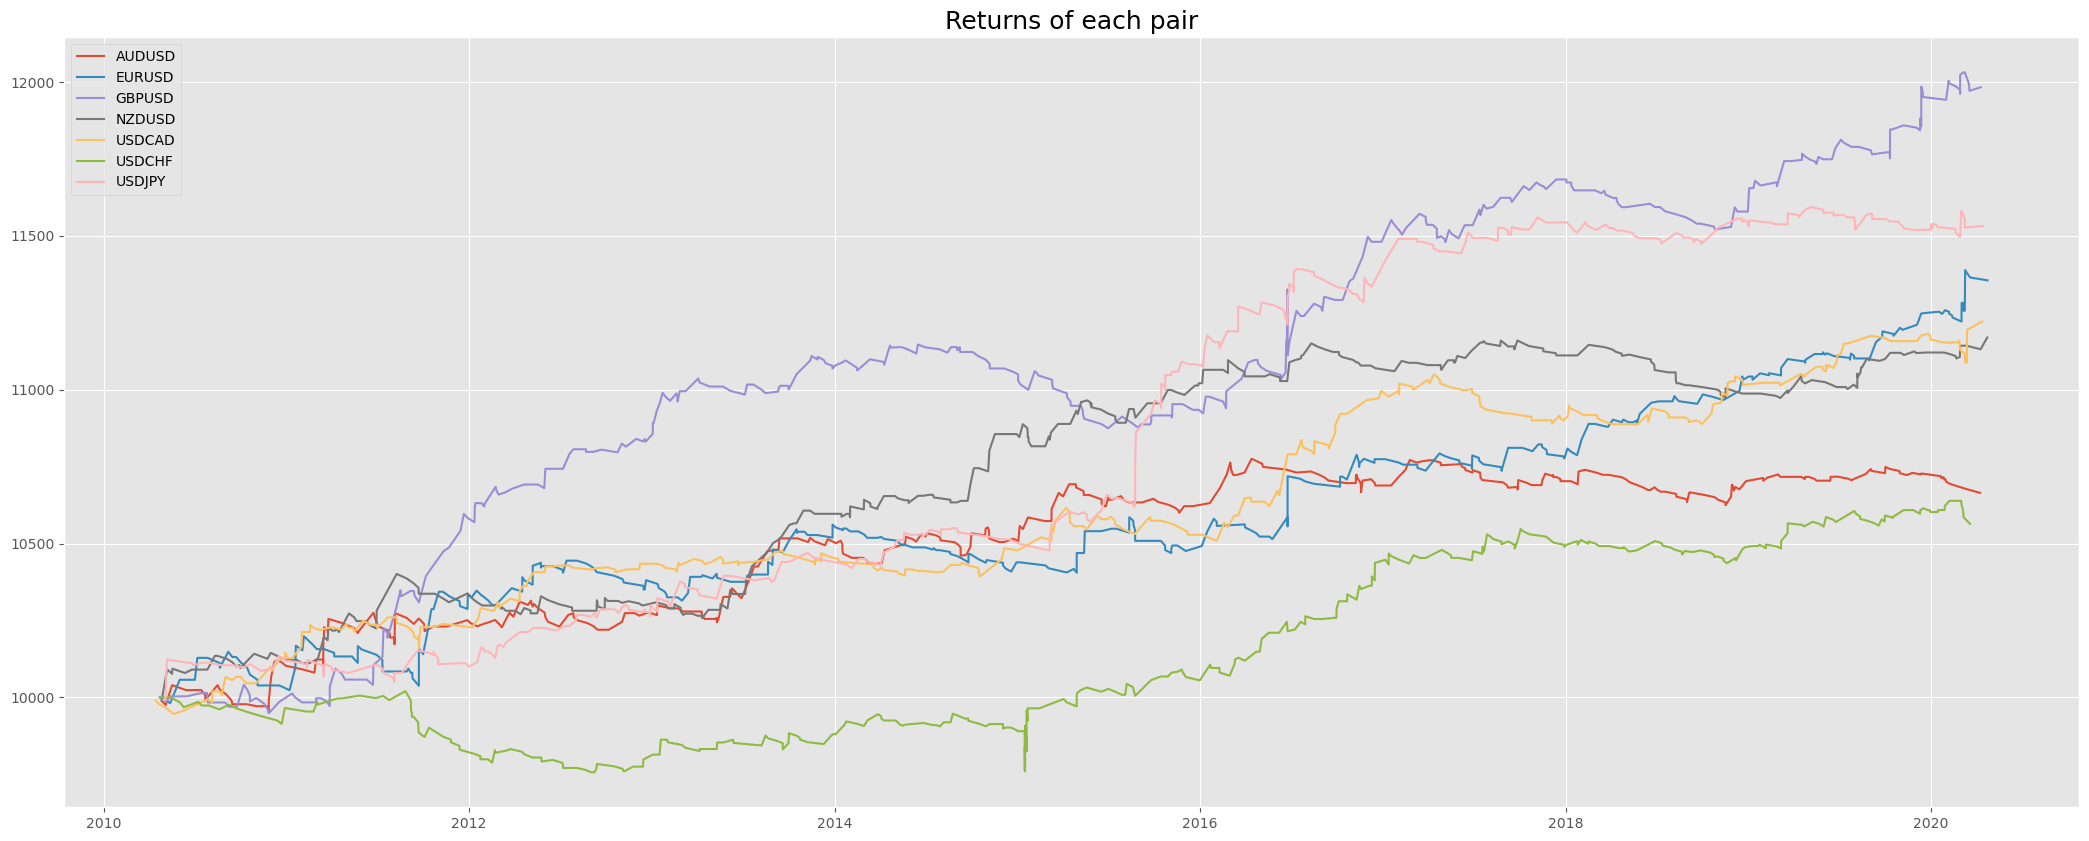

In [16]:
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [17]:

#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 6.1 %
Sharpe ratio: -0.7
Maximum drawdown 2.59 % 

Number of trades: 2587
Number of profits: 765
Number of losses: 1222
Number of breakevens: 600 

Winning percentage 38.5 %
ROI: 8490
--------------------------------
Average profitable trade: 28.55
Average lossing trade: -10.93
Max profitable trade: 163.19
Max lossing trade: -130.33


Text(0.5, 1.0, 'return of strategy')

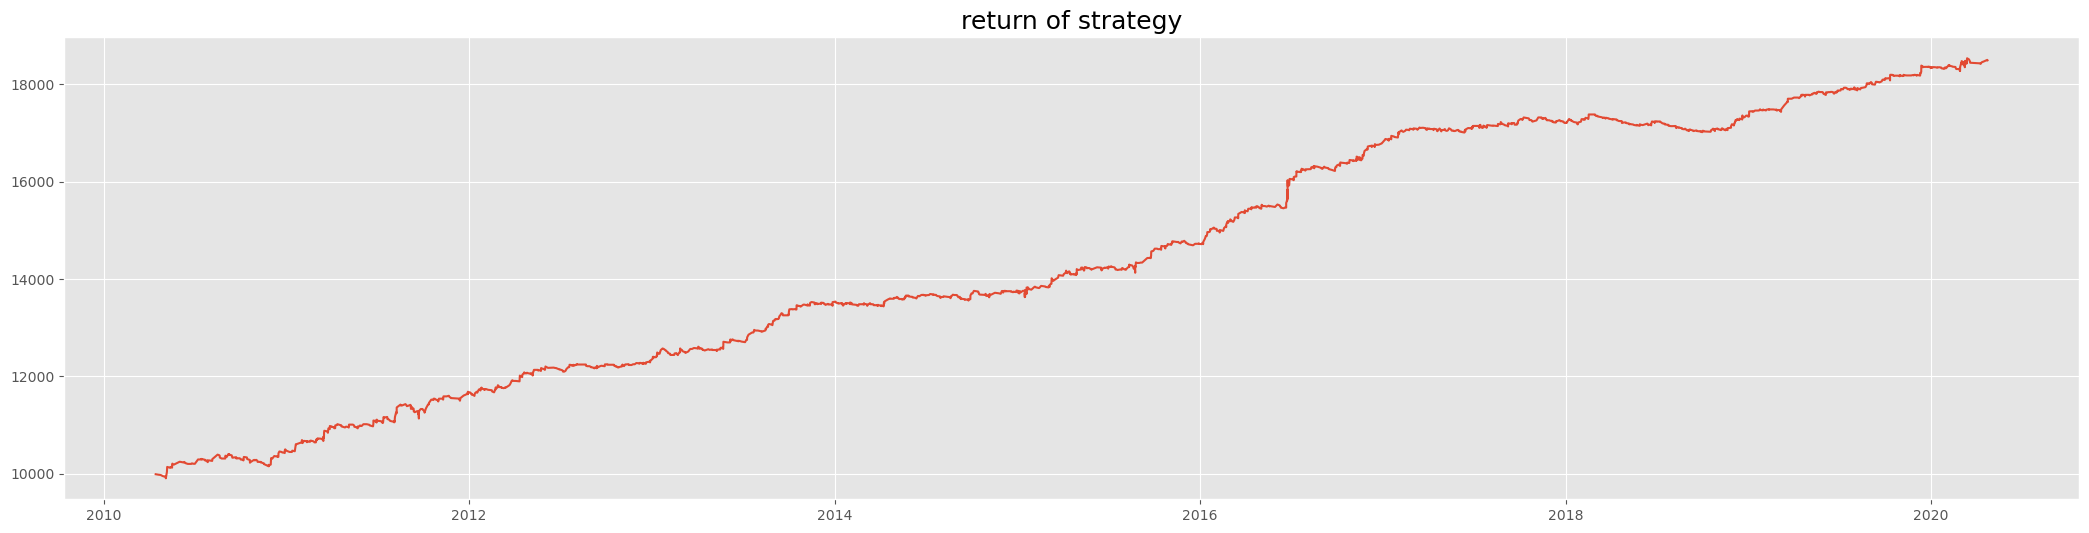

In [18]:

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)


AUDUSD - PERFORMANCE
--------------------------------
Number of trades: 382
Number of profits: 105
Number of losses: 193
Number of breakevens: 84 

Winning percentage 35.23 %
ROI: 664.51
--------------------------------
Average profitable trade: 25.09
Average lossing trade: -10.2
Max profitable trade: 101.55
Max lossing trade: -22.95
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    82
Mon    49
Sun    10
Thu    87
Tue    73
Wed    81
Name: result, dtype: int64


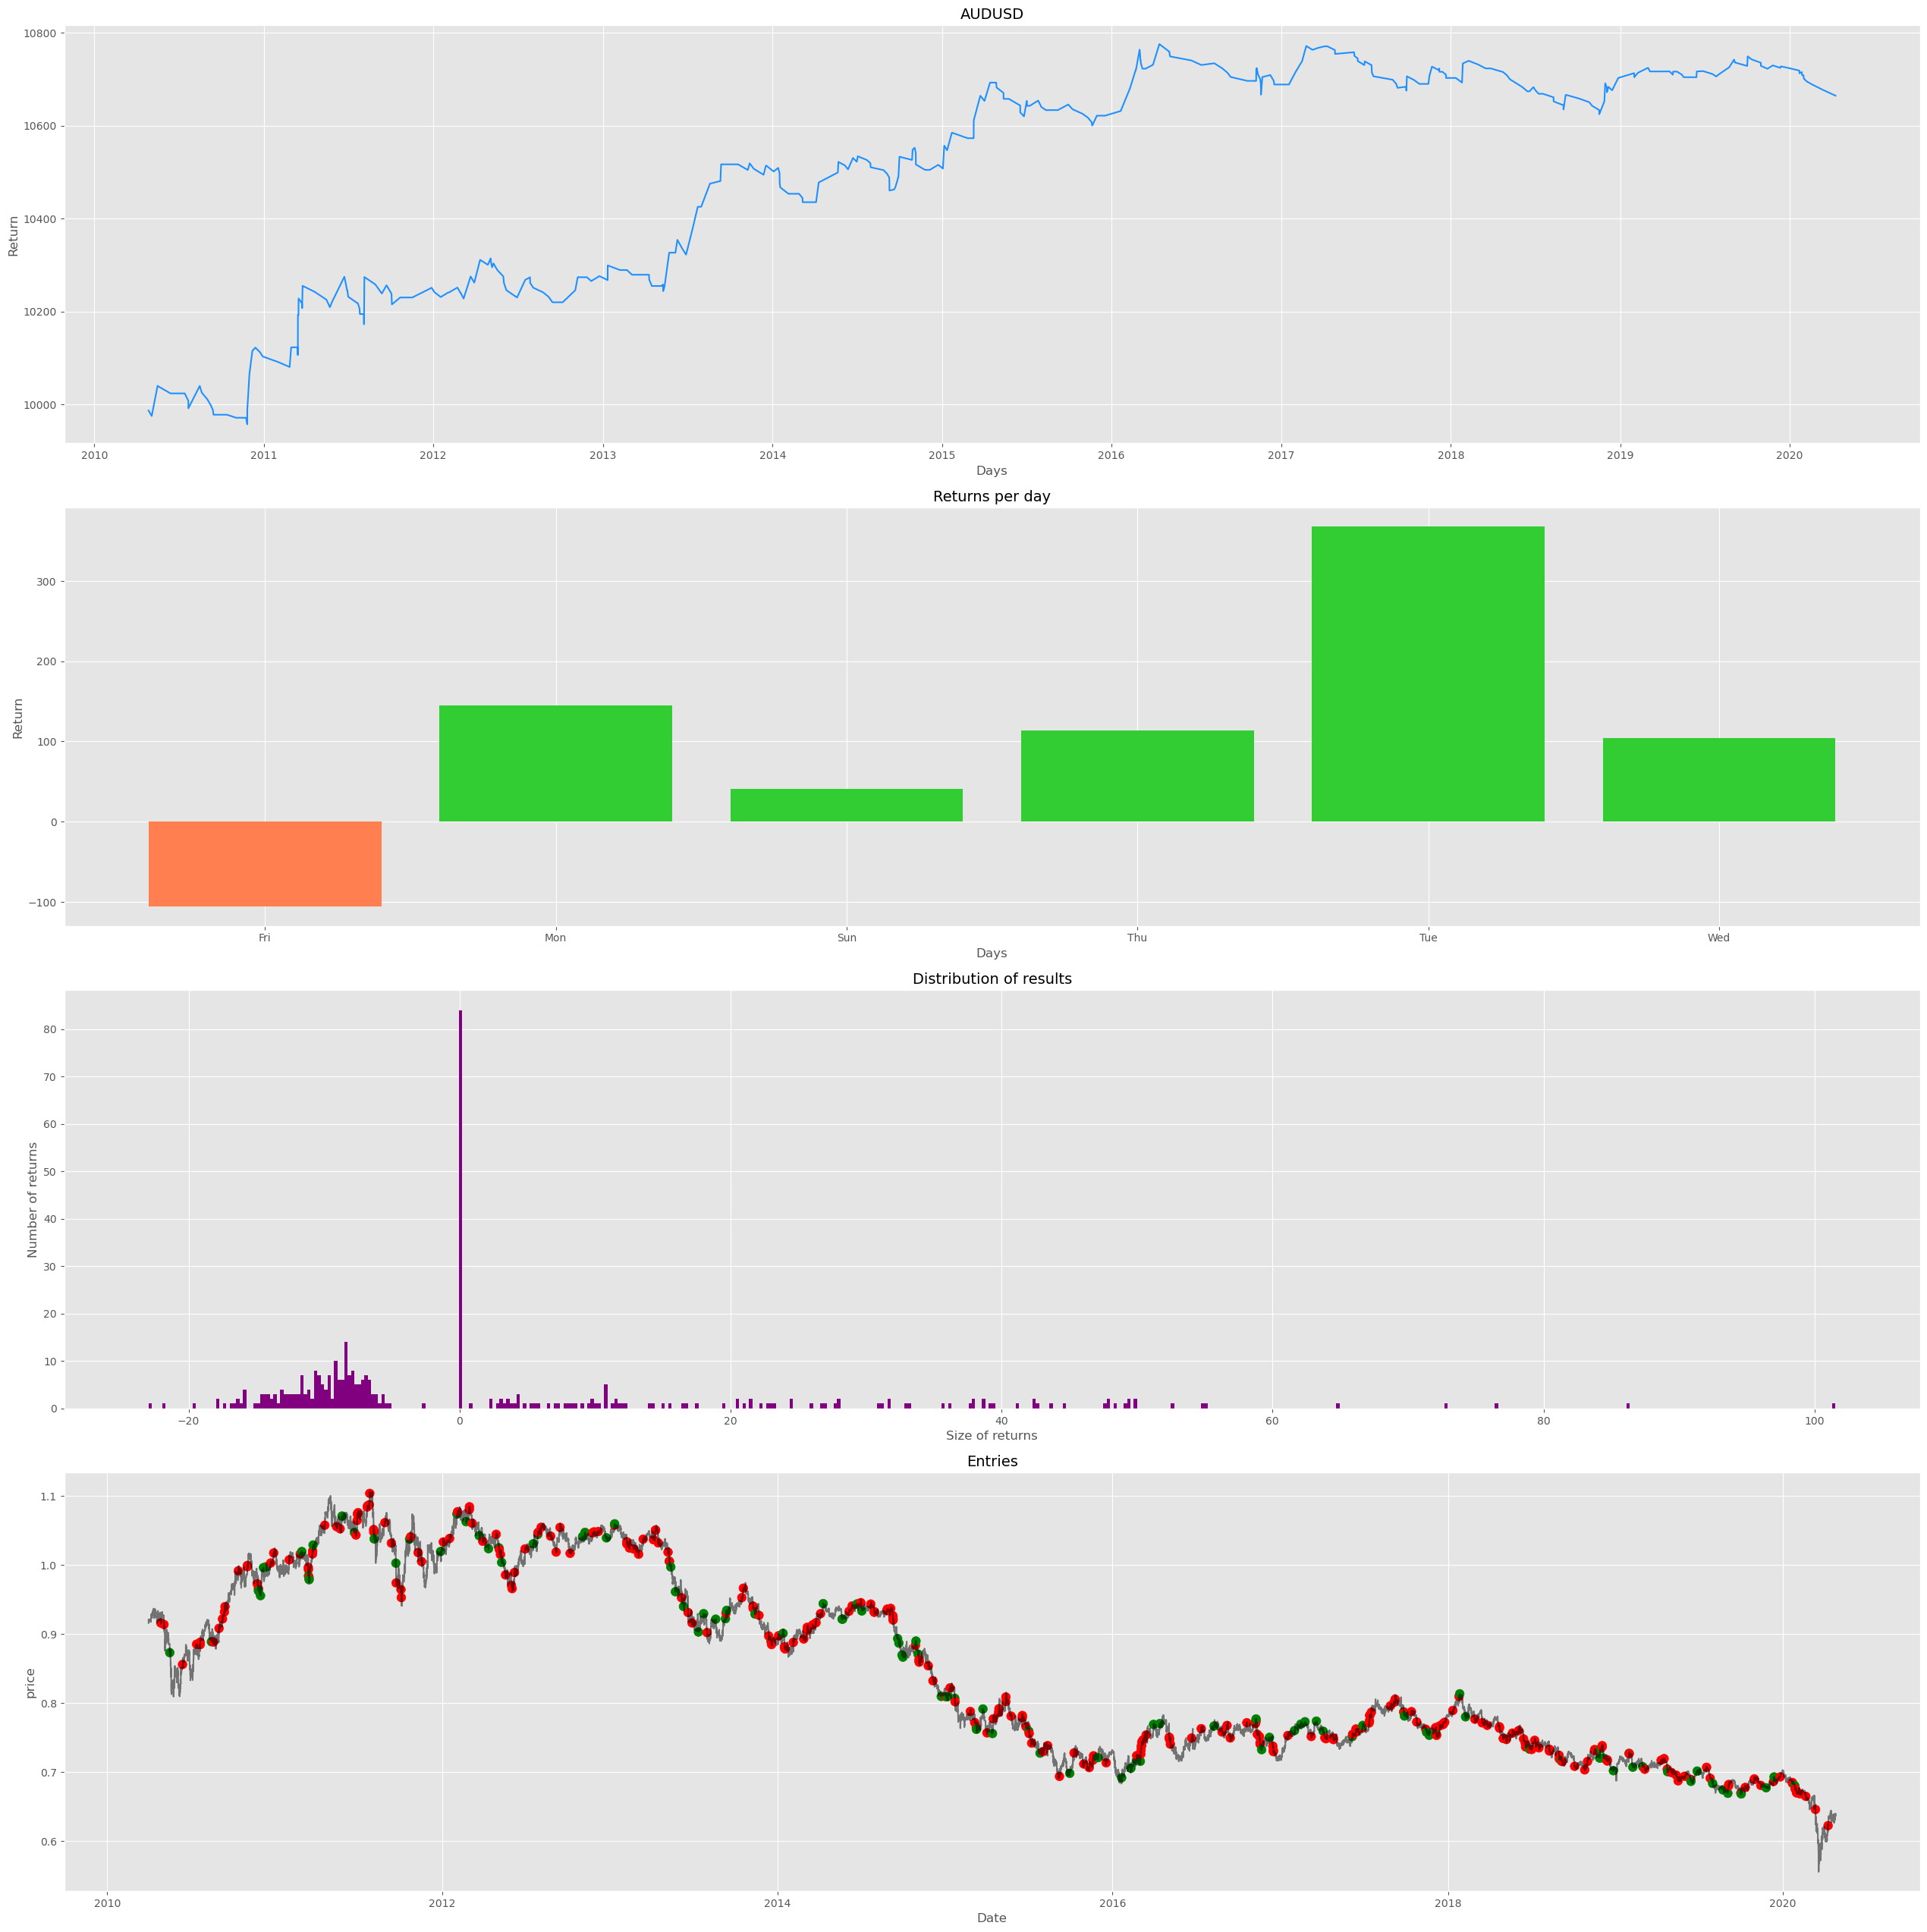

EURUSD - PERFORMANCE
--------------------------------
Number of trades: 356
Number of profits: 96
Number of losses: 176
Number of breakevens: 84 

Winning percentage 35.29 %
ROI: 1355.3
--------------------------------
Average profitable trade: 34.77
Average lossing trade: -11.26
Max profitable trade: 163.19
Max lossing trade: -30.01
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    89
Mon    45
Sun     9
Thu    88
Tue    54
Wed    71
Name: result, dtype: int64


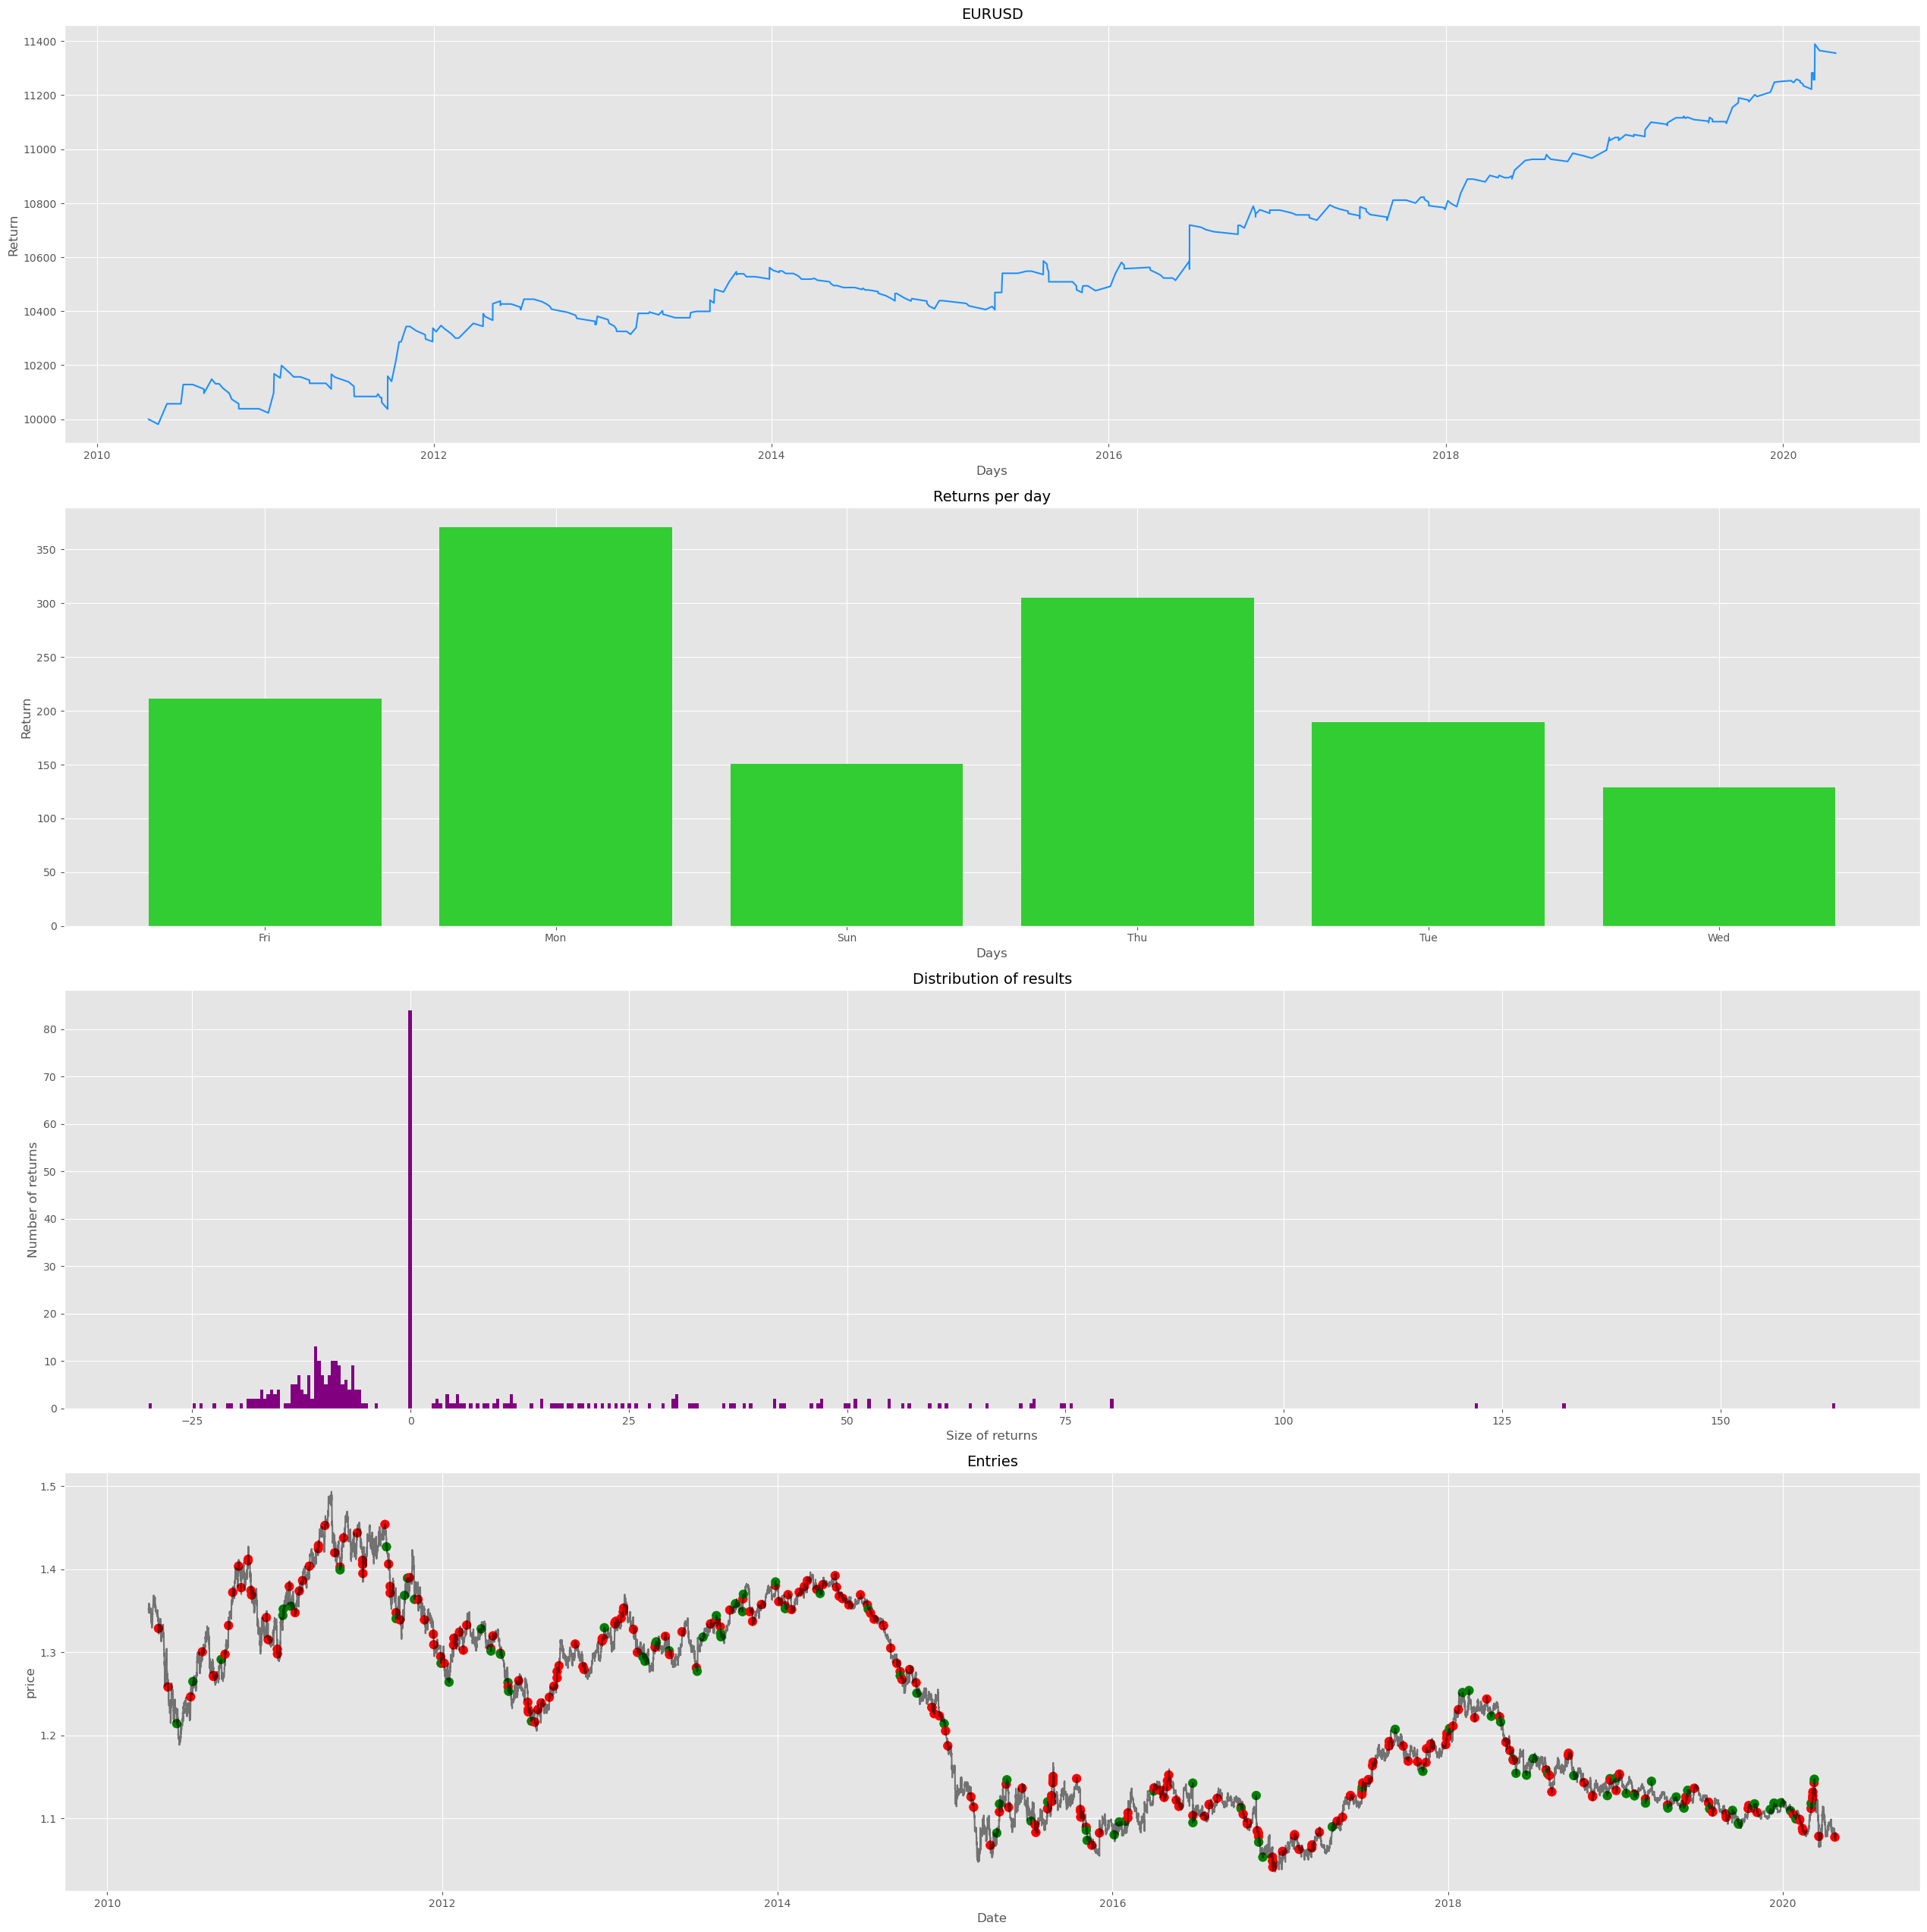

GBPUSD - PERFORMANCE
--------------------------------
Number of trades: 369
Number of profits: 122
Number of losses: 169
Number of breakevens: 78 

Winning percentage 41.92 %
ROI: 1982.93
--------------------------------
Average profitable trade: 35.38
Average lossing trade: -13.8
Max profitable trade: 153.49
Max lossing trade: -123.78
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    83
Mon    53
Sun    10
Thu    71
Tue    78
Wed    74
Name: result, dtype: int64


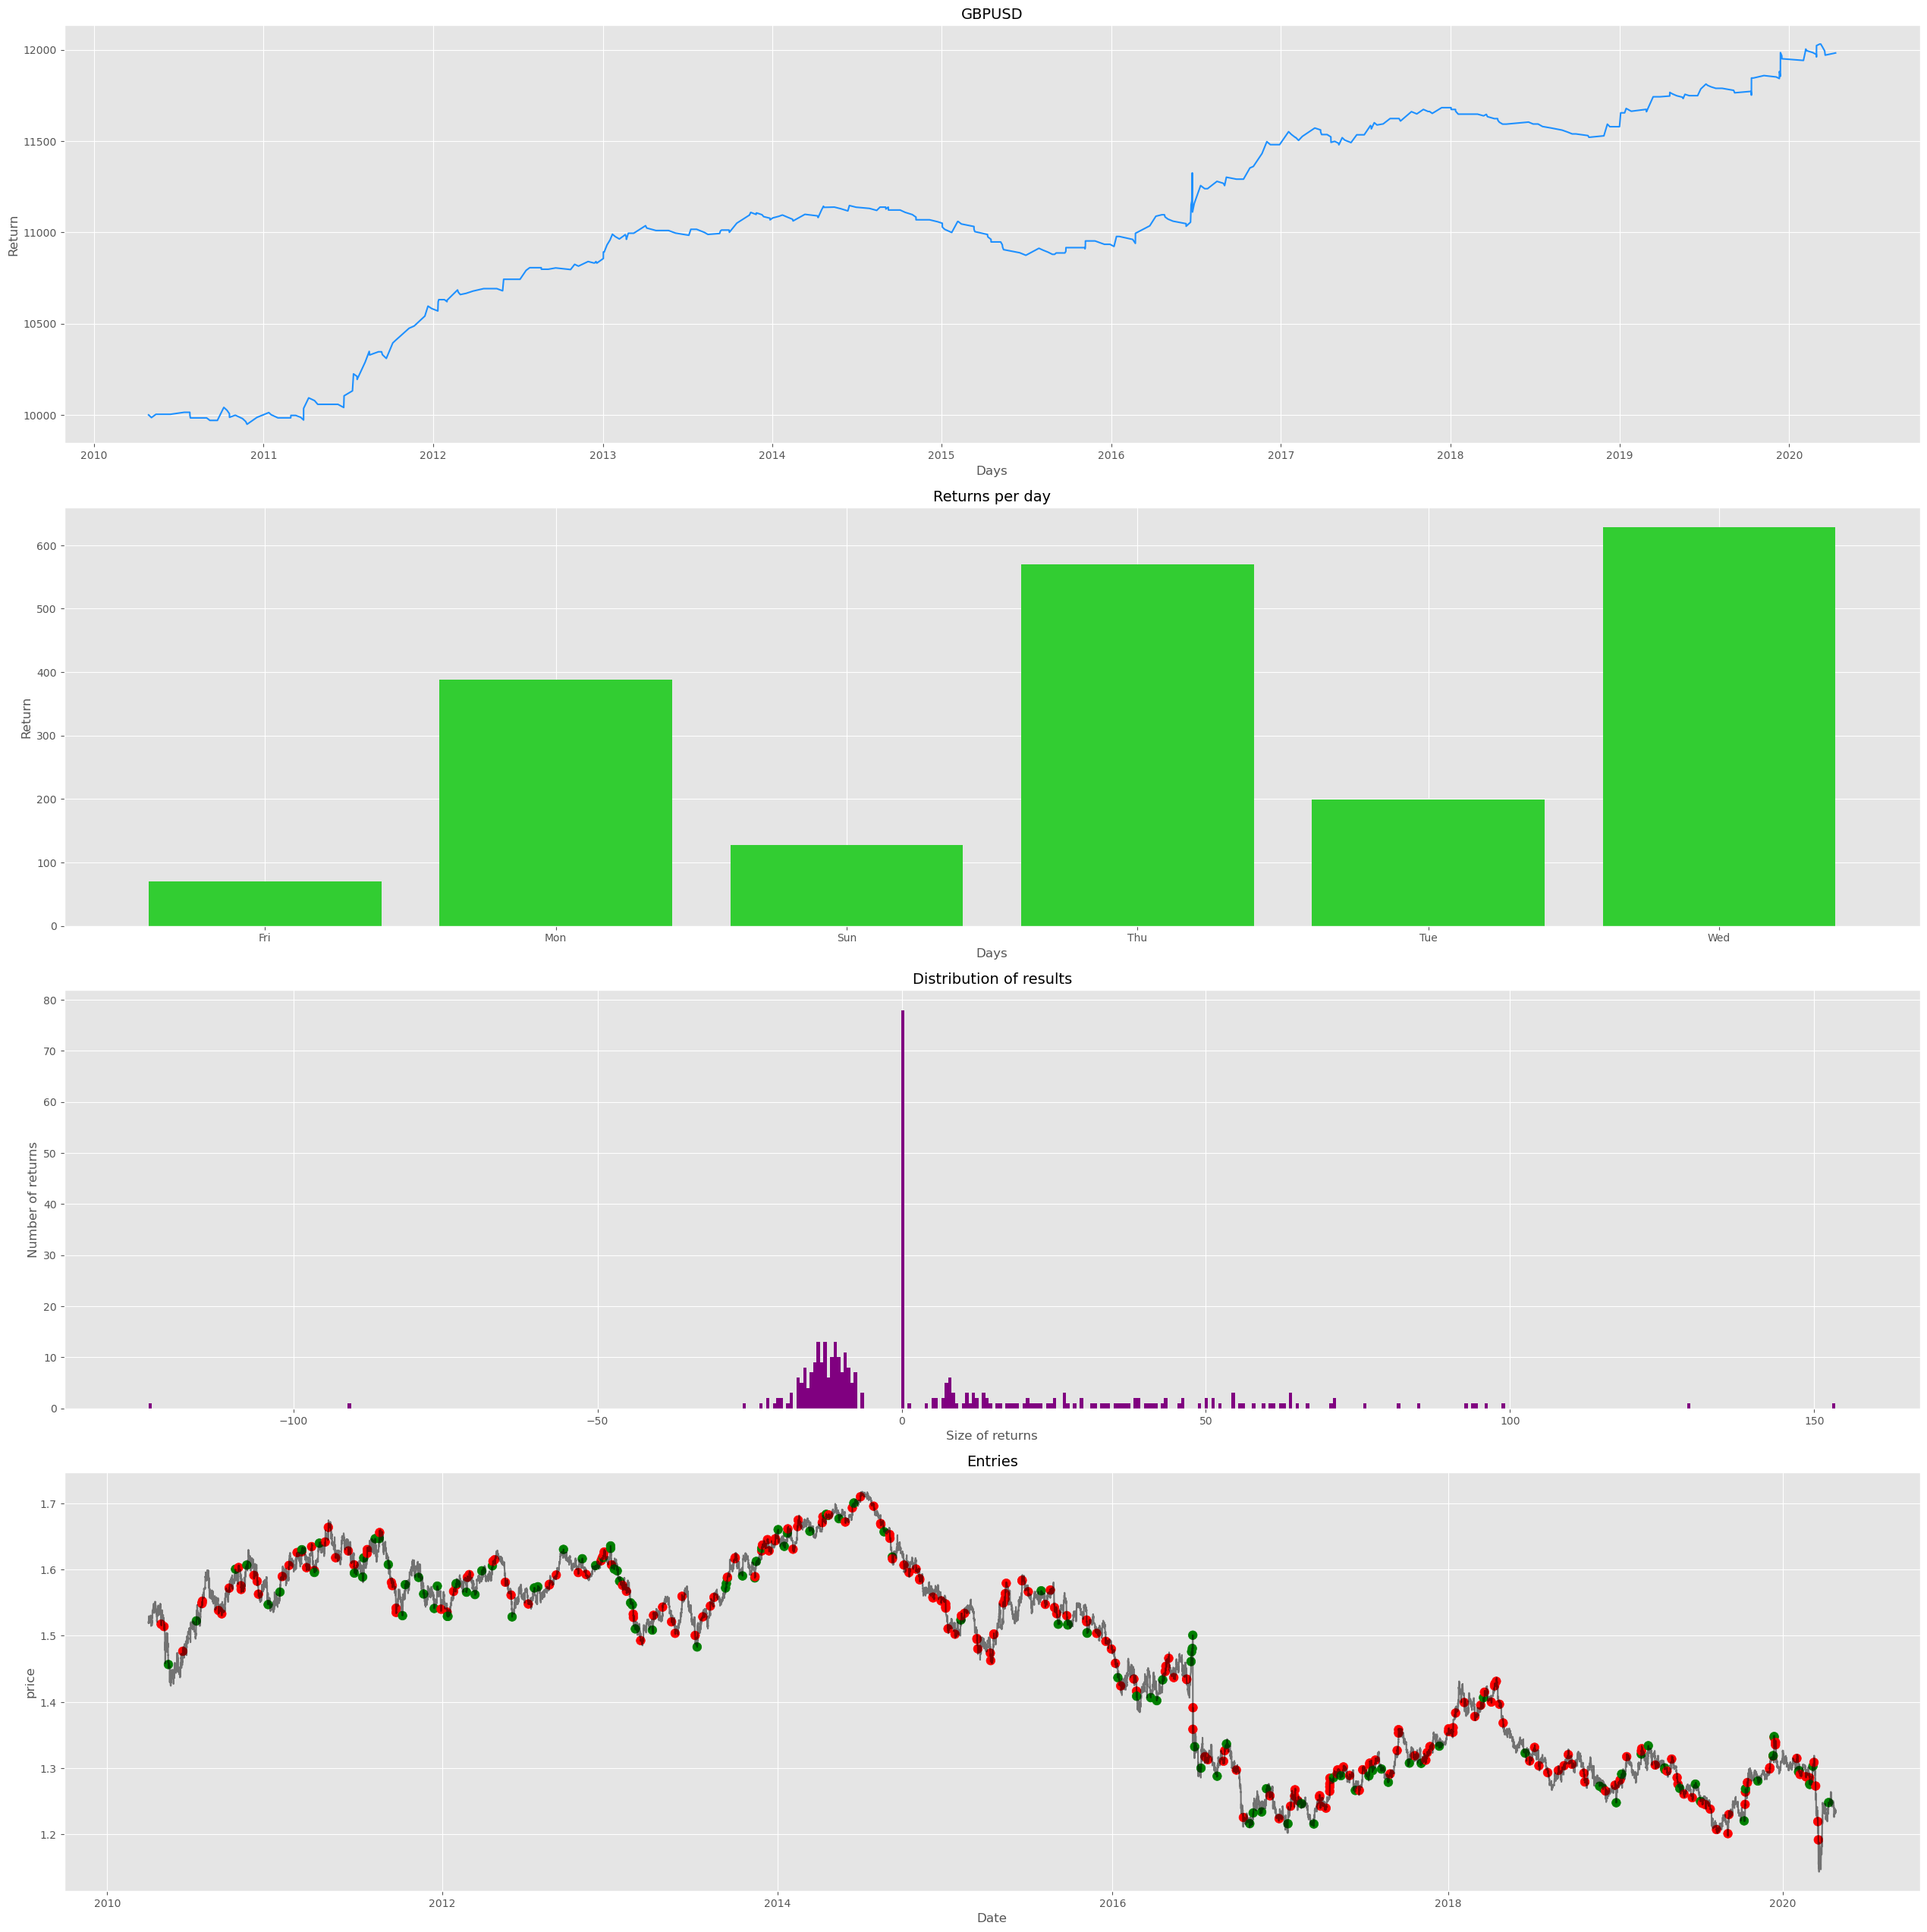

NZDUSD - PERFORMANCE
--------------------------------
Number of trades: 376
Number of profits: 99
Number of losses: 163
Number of breakevens: 114 

Winning percentage 37.79 %
ROI: 1169.84
--------------------------------
Average profitable trade: 28.1
Average lossing trade: -9.89
Max profitable trade: 118.8
Max lossing trade: -28.19
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri     75
Mon     55
Sun      4
Thu     71
Tue     70
Wed    101
Name: result, dtype: int64


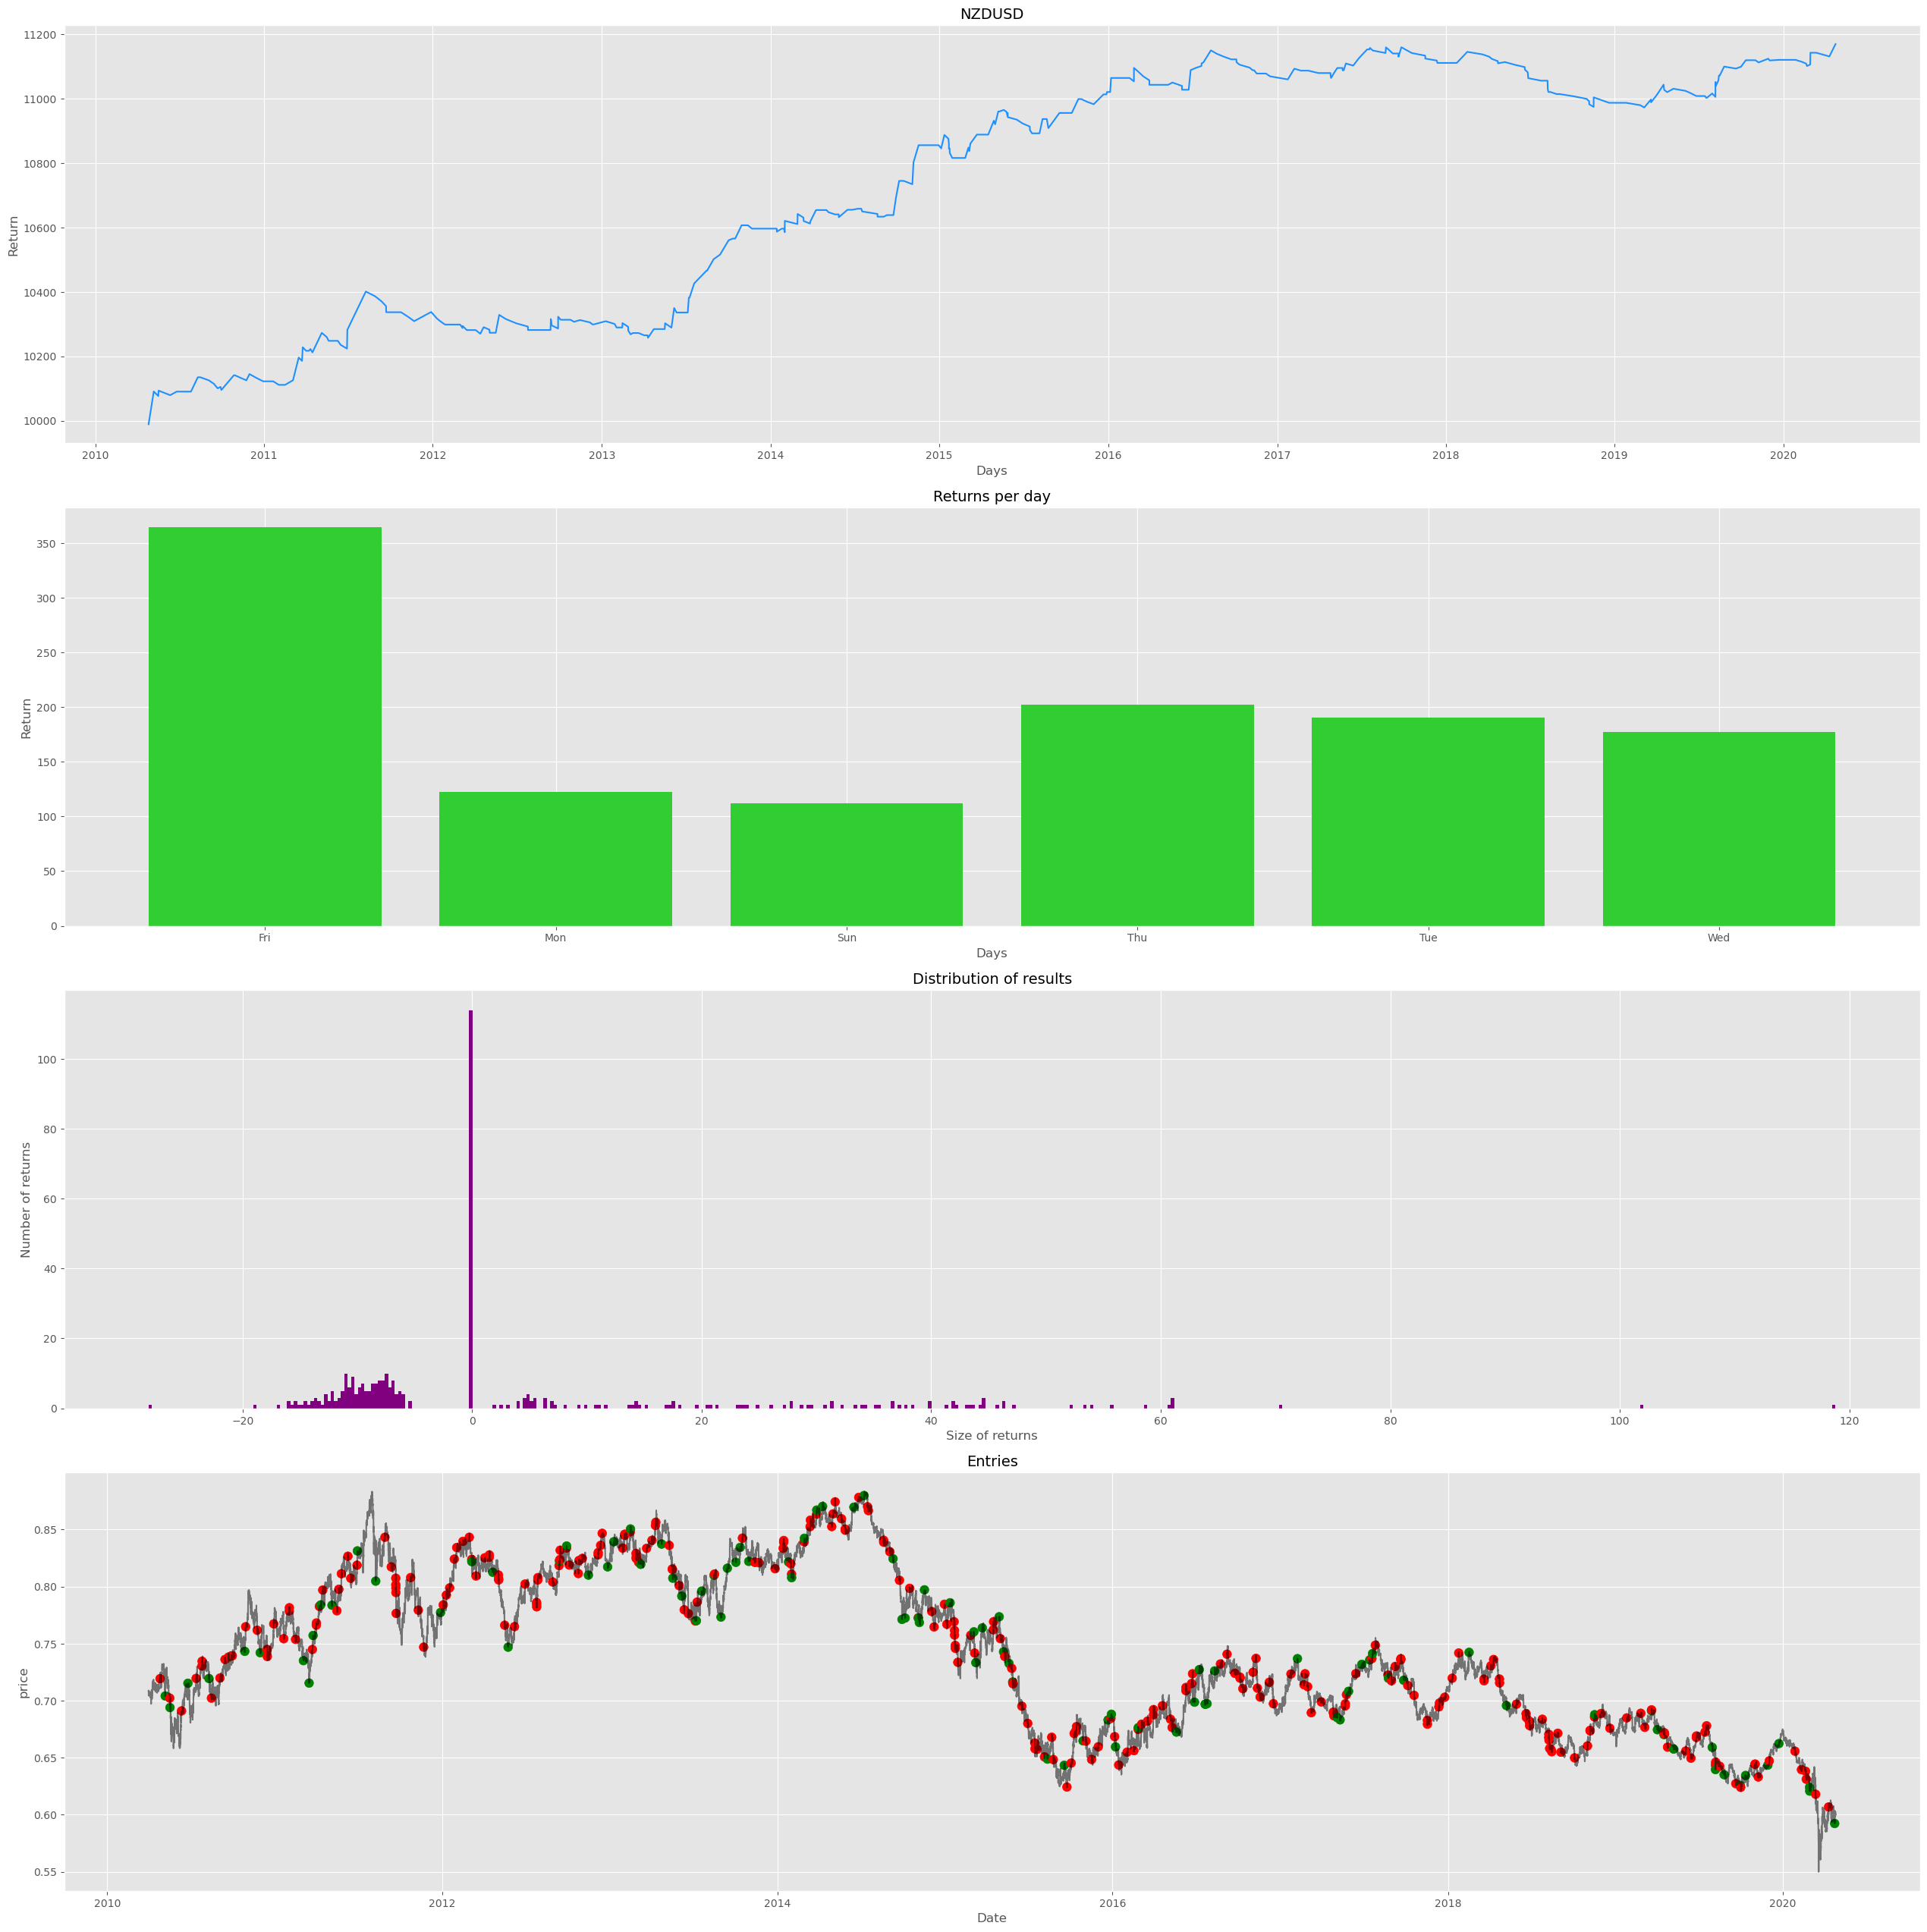

USDCAD - PERFORMANCE
--------------------------------
Number of trades: 365
Number of profits: 120
Number of losses: 157
Number of breakevens: 88 

Winning percentage 43.32 %
ROI: 1222.3
--------------------------------
Average profitable trade: 24.06
Average lossing trade: -10.61
Max profitable trade: 132.91
Max lossing trade: -28.33
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    70
Mon    47
Sun    12
Thu    69
Tue    75
Wed    92
Name: result, dtype: int64


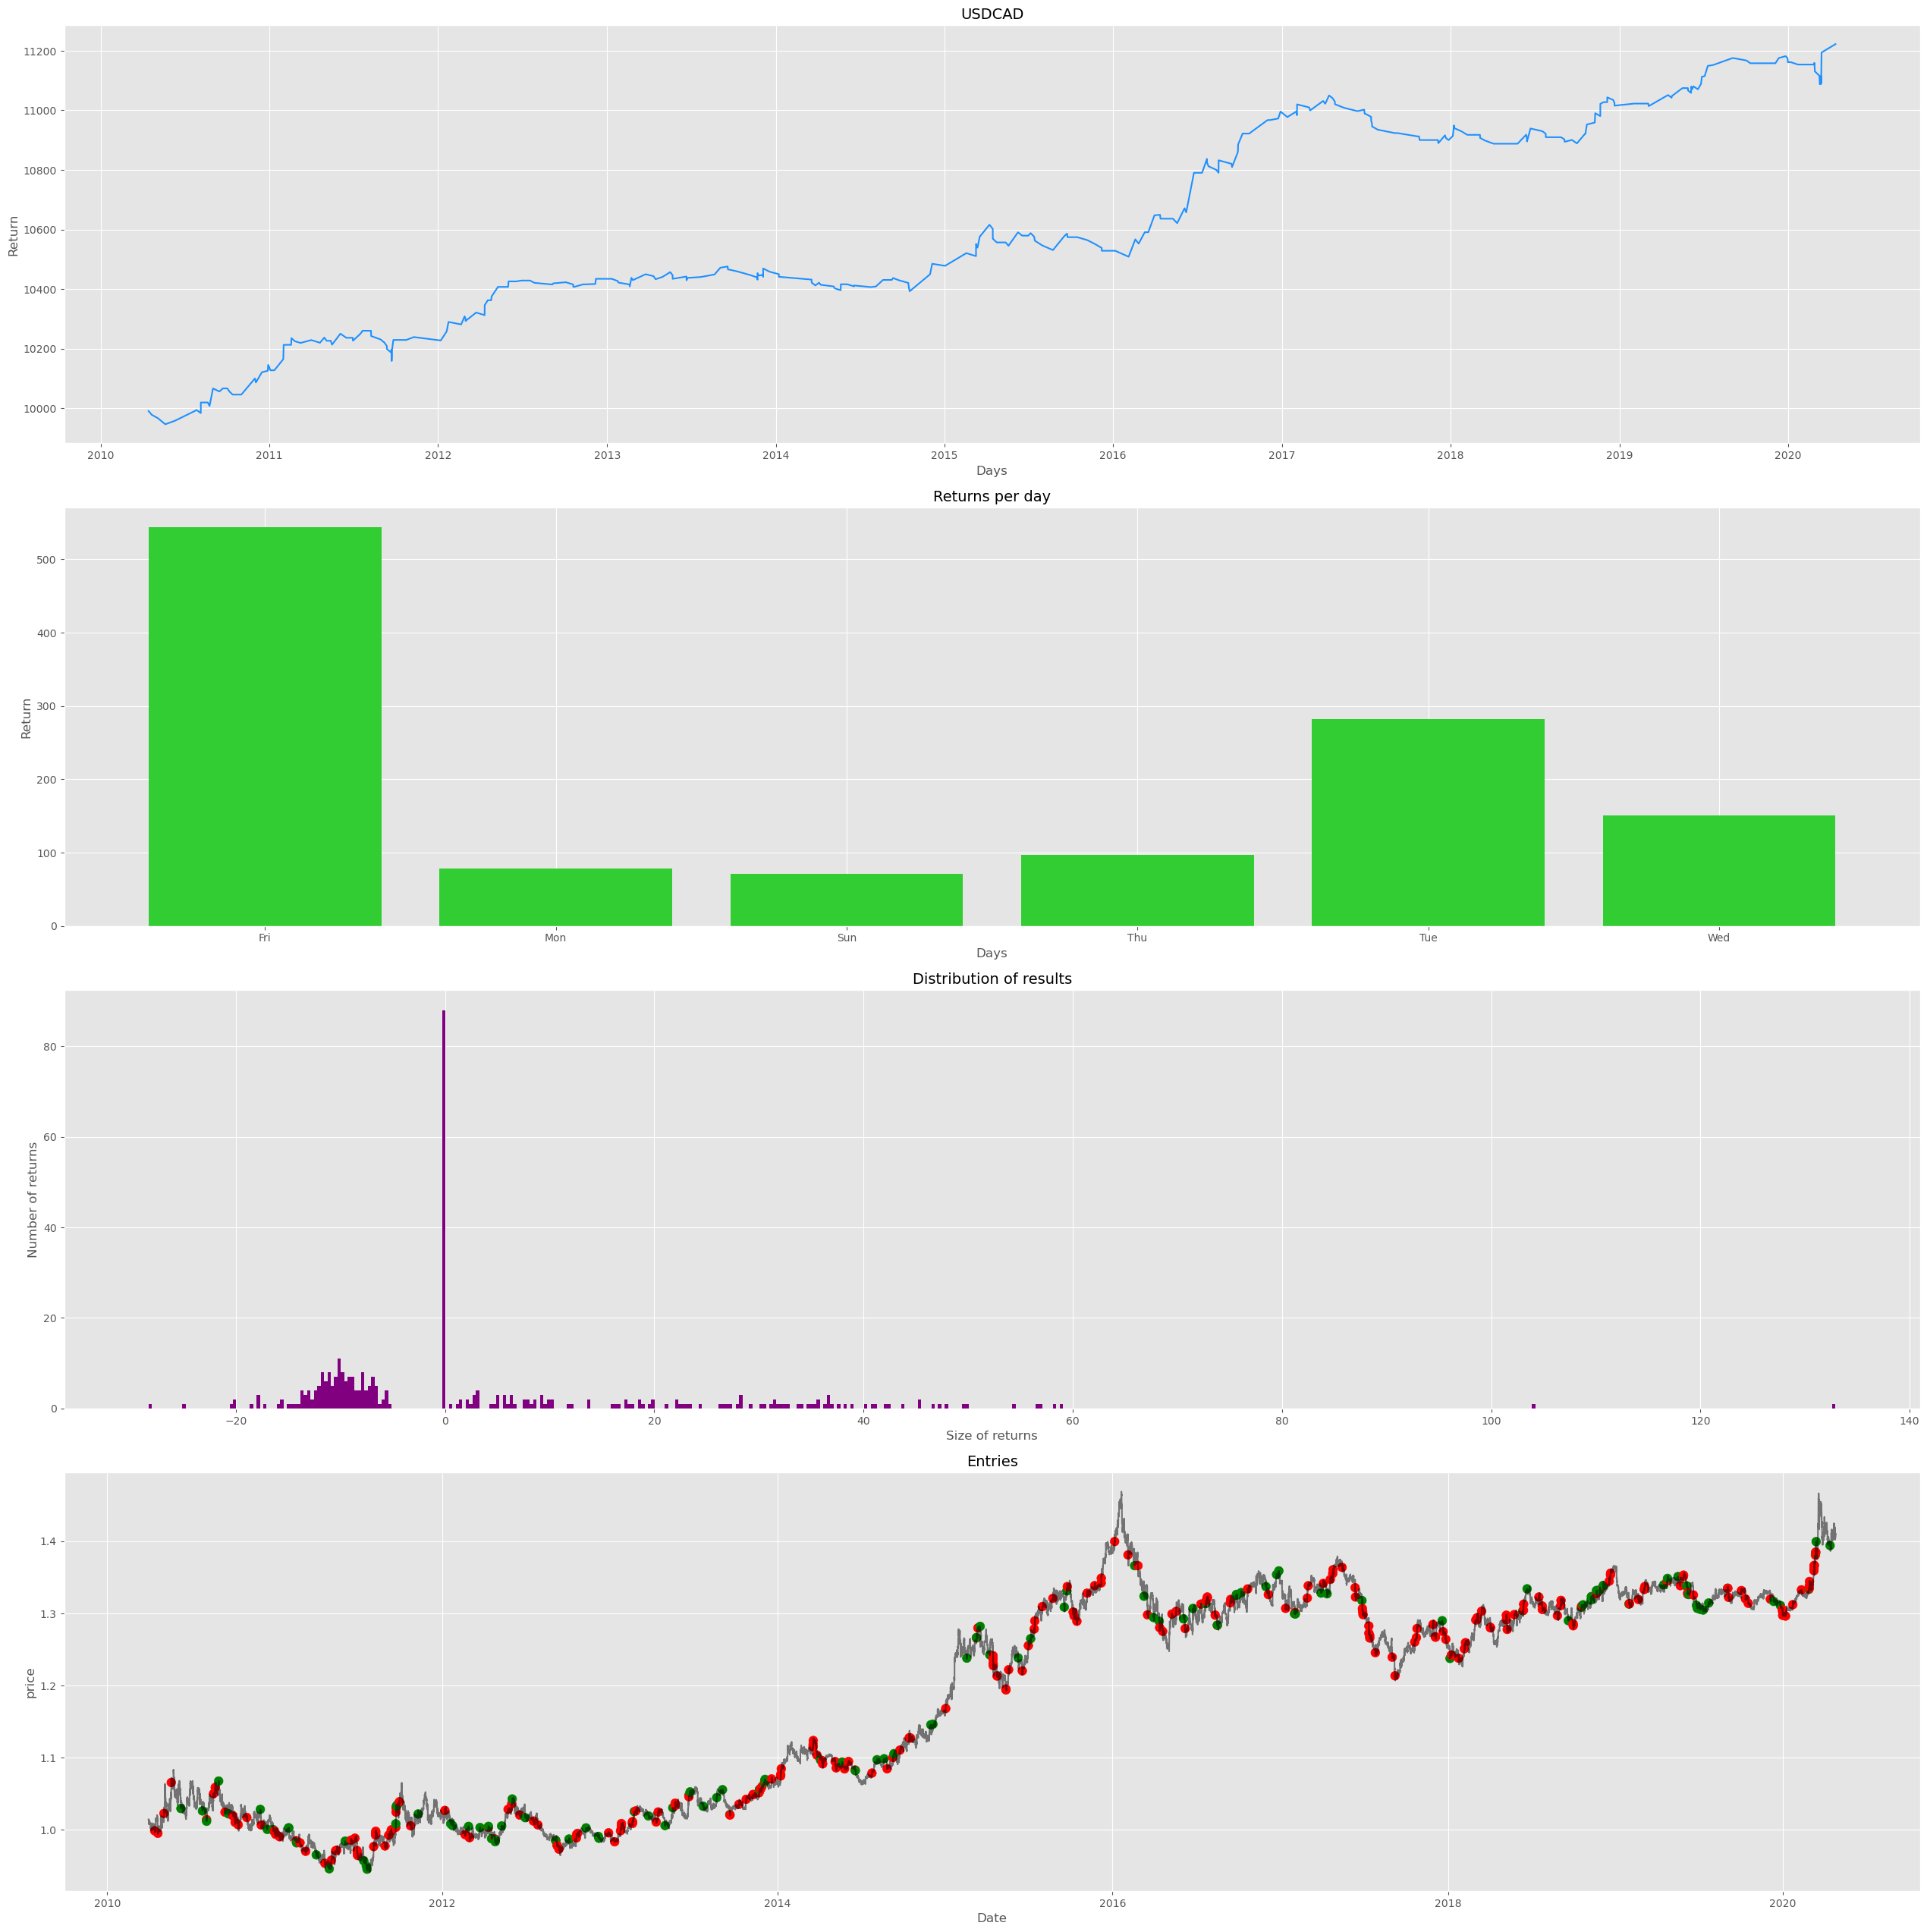

USDCHF - PERFORMANCE
--------------------------------
Number of trades: 368
Number of profits: 113
Number of losses: 183
Number of breakevens: 72 

Winning percentage 38.18 %
ROI: 563.59
--------------------------------
Average profitable trade: 22.71
Average lossing trade: -10.95
Max profitable trade: 139.7
Max lossing trade: -130.33
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    89
Mon    47
Sun     6
Thu    84
Tue    67
Wed    75
Name: result, dtype: int64


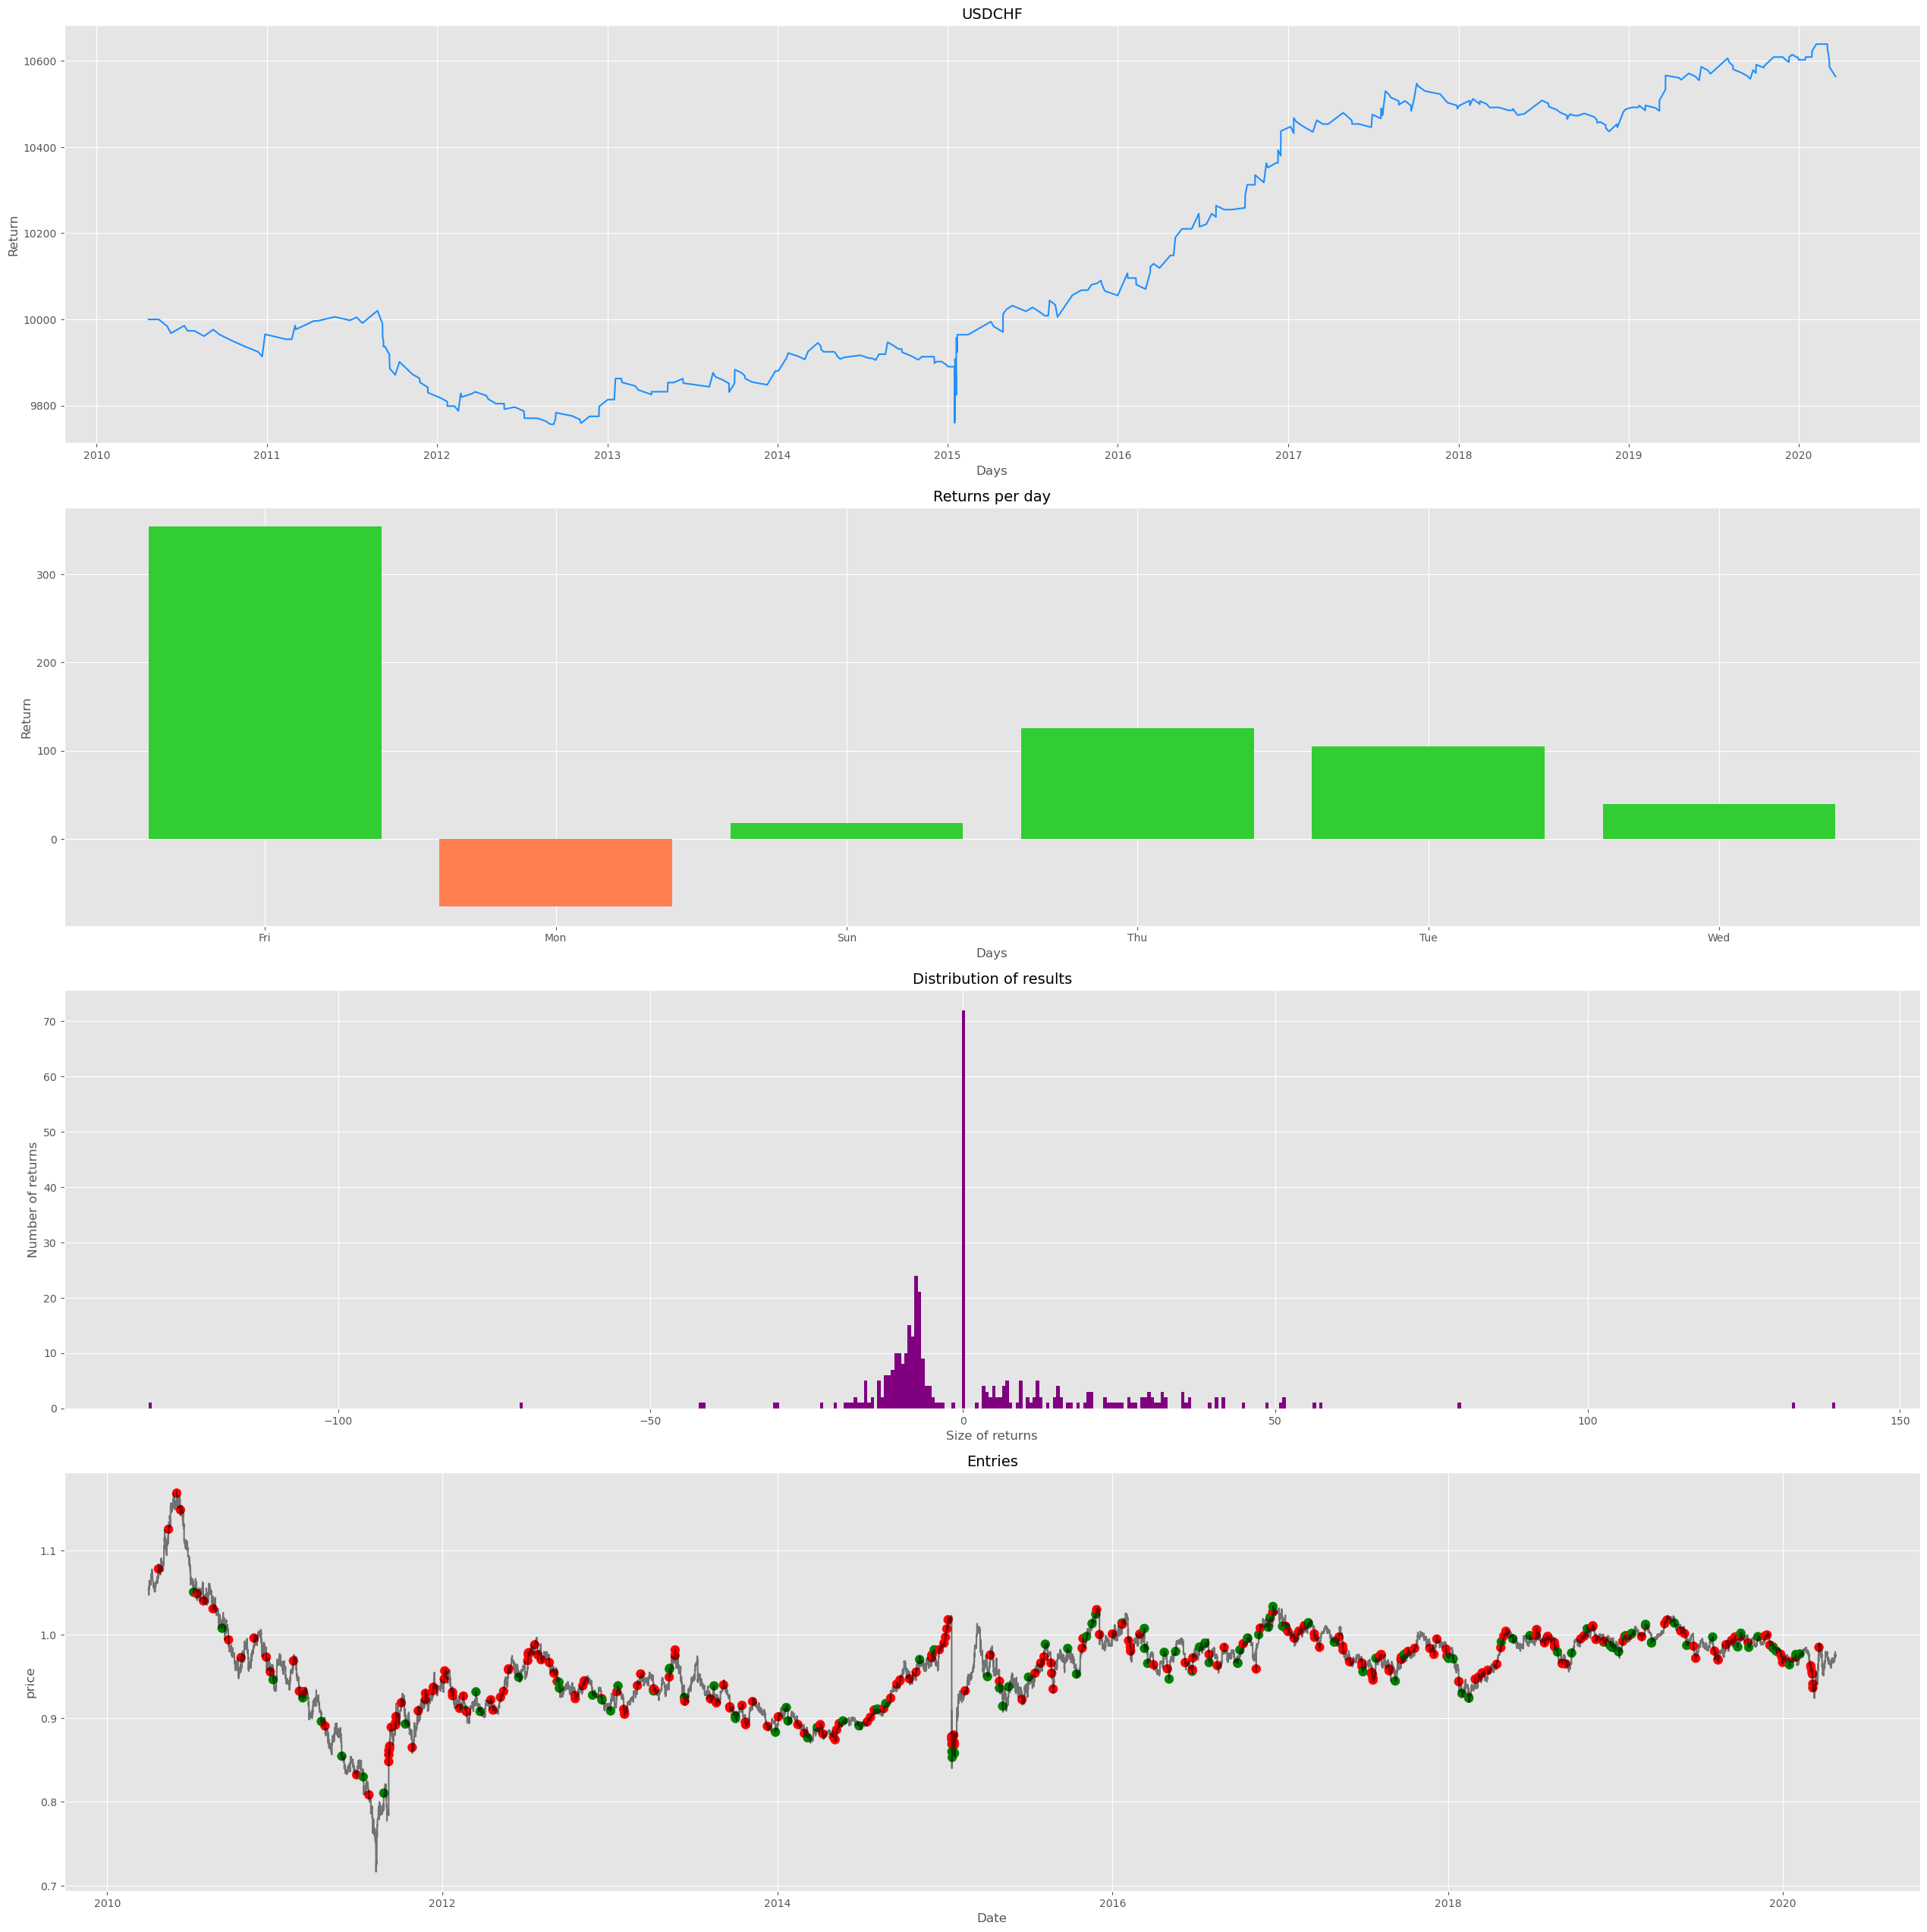

USDJPY - PERFORMANCE
--------------------------------
Number of trades: 371
Number of profits: 110
Number of losses: 181
Number of breakevens: 80 

Winning percentage 37.8 %
ROI: 1531.89
--------------------------------
Average profitable trade: 30.18
Average lossing trade: -9.88
Max profitable trade: 141.15
Max lossing trade: -48.21
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    82
Mon    52
Sun    13
Thu    86
Tue    67
Wed    71
Name: result, dtype: int64


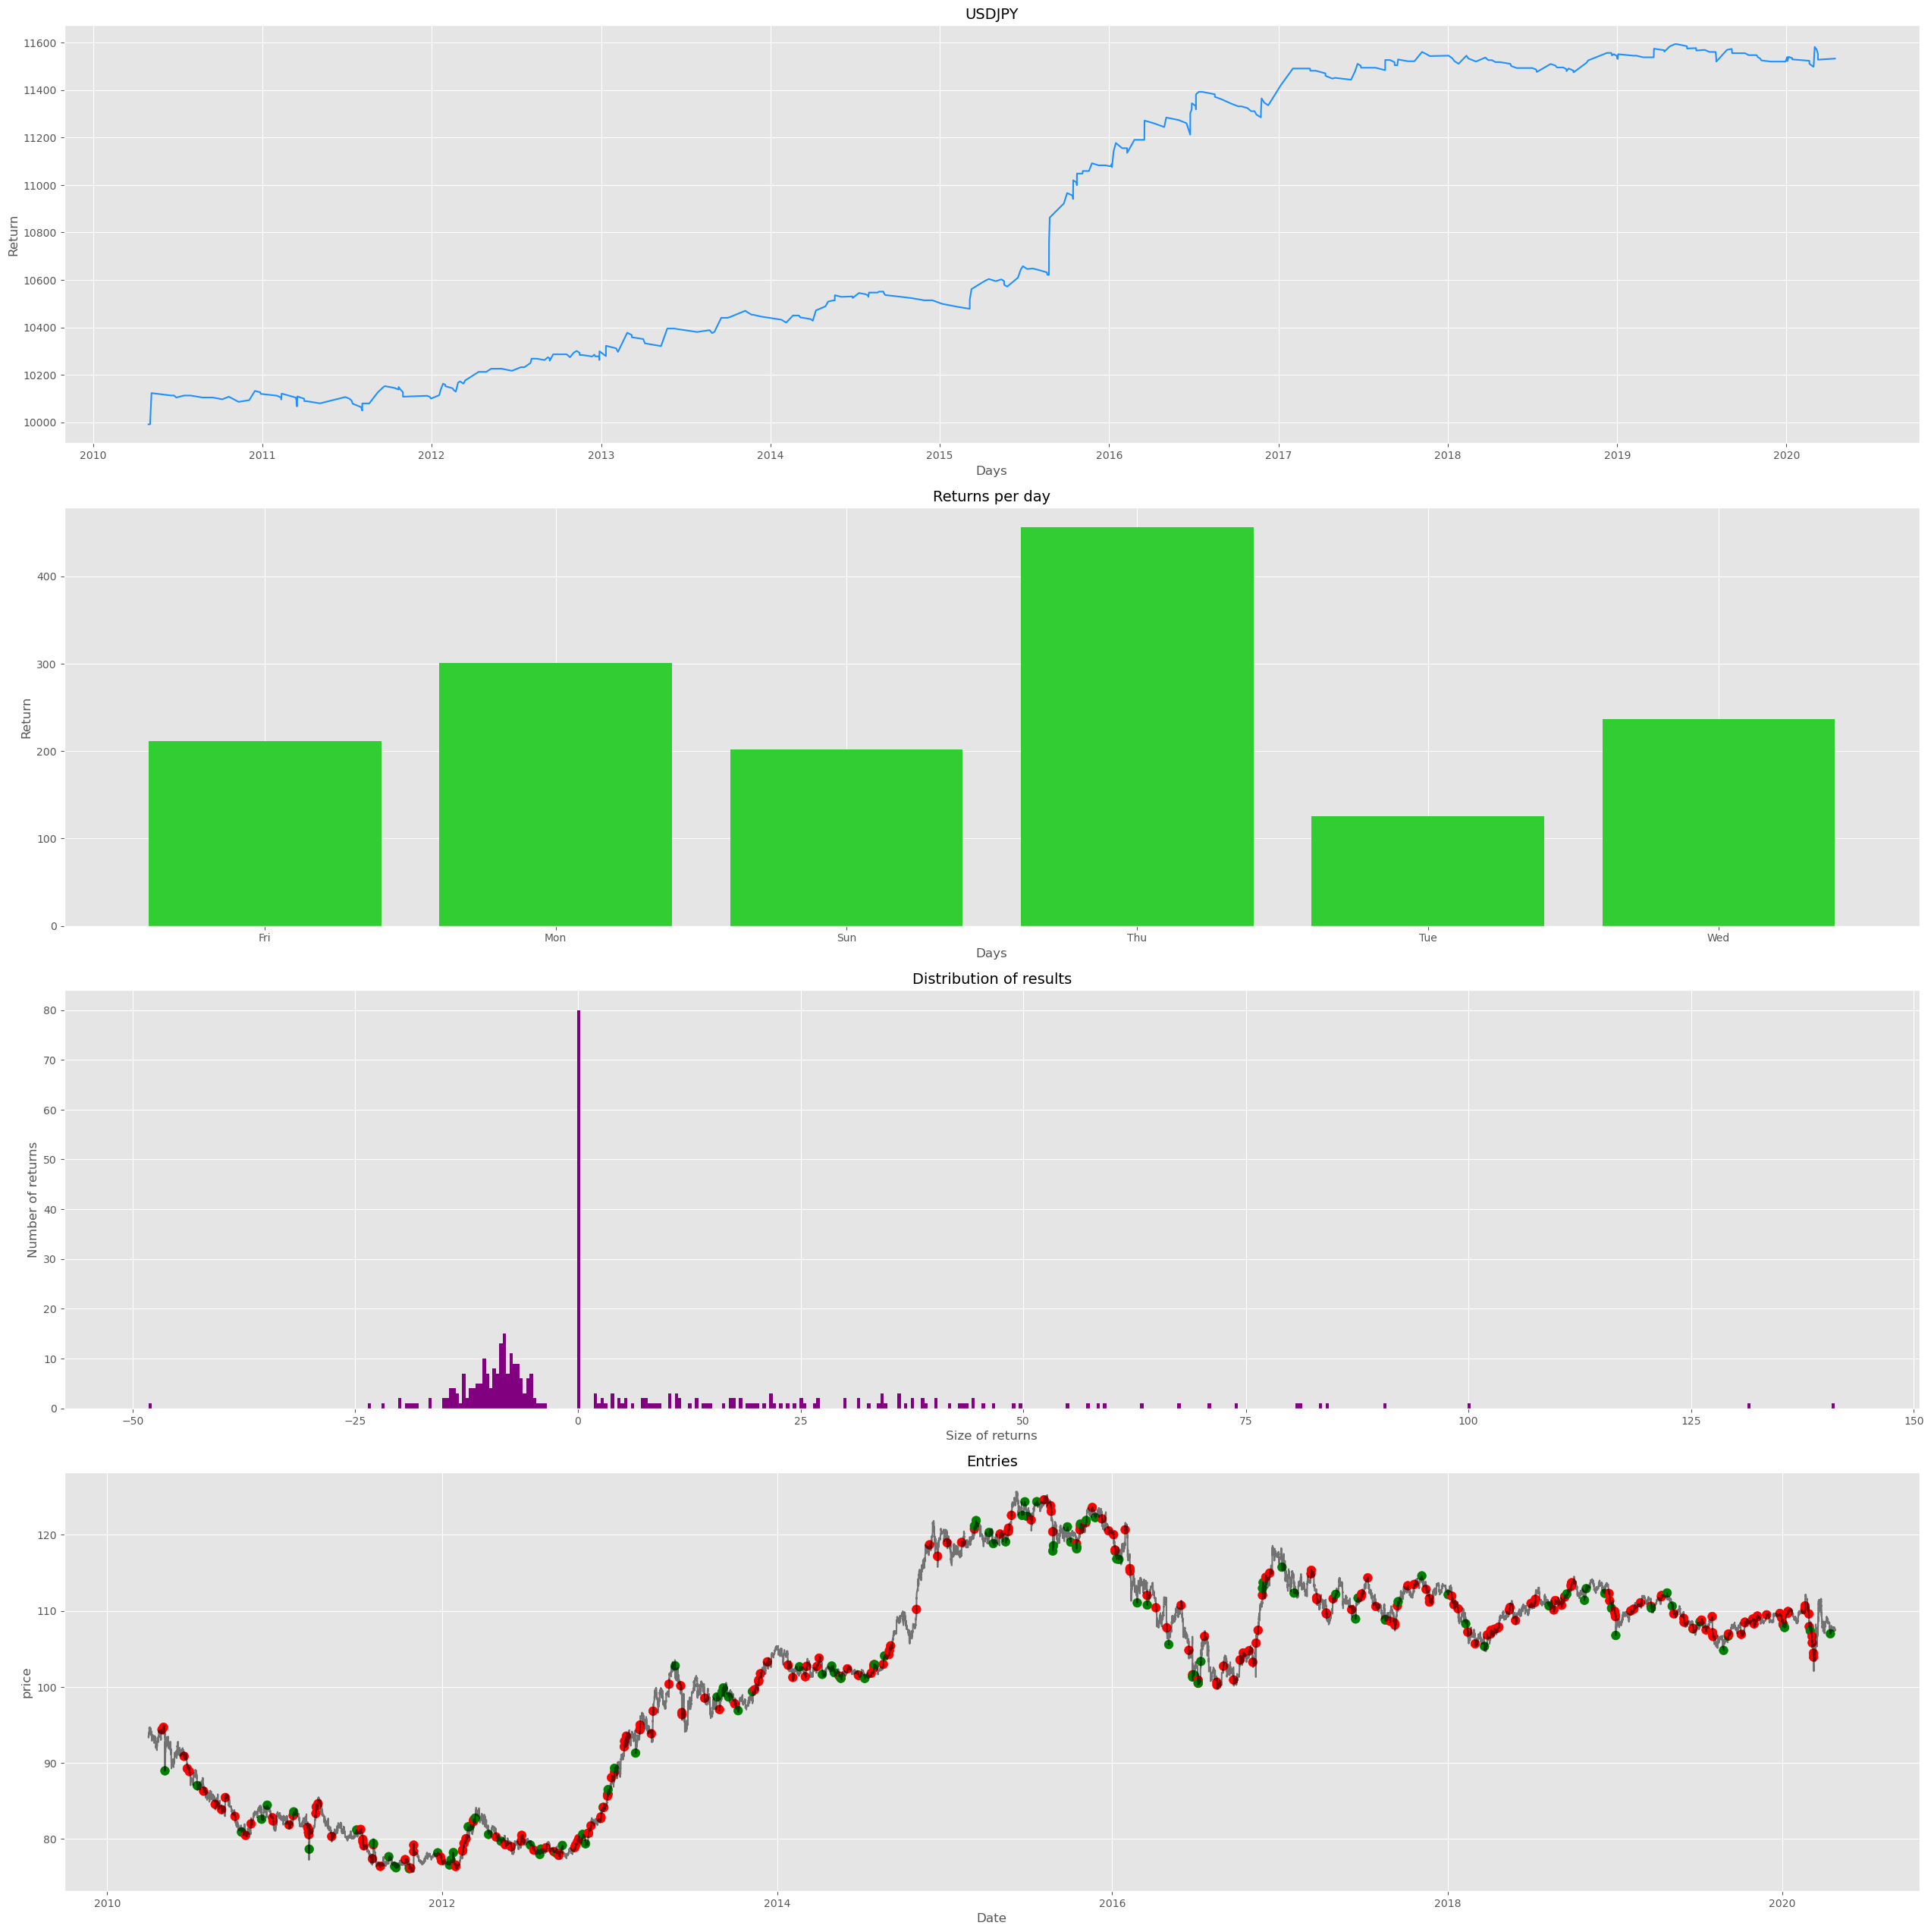

In [19]:

#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')

    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    positive_results = pairs_results[pair]['result'] > 0

    print('Number of trades per day \n', trades_per_day)

    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)

    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')

    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')

    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')

    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = positive_results.map({True: 'green', False: 'red'}))
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')

    plt.show()
